# **The Data**
I will be using a subset of the Owner.com product analytics dataset, provided for interview purposes by the Owner data science team.

Owner is a fast-growing technology company on a mission to help independent restaurants thrive by increasing their direct online orders, optimizing guest experiences, and improving overall profitability. This case study leverages real product data to demonstrate my ability to define success metrics, identify key business drivers, and ensure data integrity—skills that are core to supporting Owners mission through data-informed decision making.



# **Goal**
The task involves three aspects:


**1. Metrics design**
- Propose key metrics that should reflect the health and success of our product from the perspective of our customers (restaurant locations) and their guests. These metrics should help us understand at a glance the health of our product, making sure we can assess if the product is delivering on the value.

**2. Key drivers analysis**
- Analyze trends over time using the metrics you have developed. Assess whether there is an upward trend in the value delivered to customers (both restaurants and their guests).
Identify key drivers that may be influencing these trends.
- Compare the performance metrics between App and Web usage to determine differential behaviors or preferences.

**3. Data quality assessment**
- Identify any potential data quality issues within the dataset provided. Discuss how these issues could impact the analytics and suggest methods for monitoring and remedying these problems moving forward.

## **0. Setup**

In [ ]:
!pip install snowflake-connector-python

In [ ]:
import snowflake.connector
import pandas as pd
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
from datetime import datetime
from datetime import timedelta
from scipy.stats import gaussian_kde
from scipy.stats import ttest_ind

# Settings
pd.set_option('display.float_format', '{:.2f}'.format)
#sns.set(style='whitegrid', palette='pastel')

In [ ]:
conn = snowflake.connector.connect(
        user='de_case_hirakbhayani',
        password='!@#fAA1f22f1kAaG3F1',
        account='GVSZSBN-TEA10269',
        warehouse='CASE_WH',
        database='demo_db',
        schema='public')

In [ ]:
try:
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM product_analytics_case_v2")
    rows = cursor.fetchall()
    column_names = [desc[0] for desc in cursor.description]

    # Write to CSV
    with open("product_analytics_sample.csv", mode="w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(column_names)
        writer.writerows(rows)

finally:
    cursor.close()
    conn.close()

In [ ]:
df = pd.read_csv("product_analytics_sample.csv")
print(df.head())

                           ORDER_ID                          BRAND_ID  \
0  e64a58dcd4a5ea2b884ec5f22465ac91  83a8a24d62b21c116f30cd4d122695de   
1  b19900ddf43735d0c9f981a26bbd7d30  83a8a24d62b21c116f30cd4d122695de   
2  8a2424ffb398ab3f8413a7ffe9fbac13  83a8a24d62b21c116f30cd4d122695de   
3  5cd3324129c9f7641fb6d4a23312d5d5  83a8a24d62b21c116f30cd4d122695de   
4  f88316d70860acfae4518334cea9bb9f  83a8a24d62b21c116f30cd4d122695de   

                        LOCATION_ID                          GUEST_ID  \
0  99097ac5962140987c95a08cb162b048  e4d96189f4d608071e6be854cbfd033c   
1  99097ac5962140987c95a08cb162b048  7ed13288661489f4c67649fa5ddefb44   
2  99097ac5962140987c95a08cb162b048  71356de622081574f4d6b0b3ca766477   
3  99097ac5962140987c95a08cb162b048  a36374a29fadeef80ec88cca79876137   
4  99097ac5962140987c95a08cb162b048  f39d828305260319efa2511c9b93f49d   

          ORDER_CREATED_AT_PT ORDER_TYPE ORDER_SOURCE DELIVERY_TYPE  \
0  2025-03-06 08:43:07.381000     pickup          W

# **1. Checking the shape, size and other details of our dataset**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1514681 entries, 0 to 1514680
Data columns (total 15 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   ORDER_ID             1514681 non-null  object 
 1   BRAND_ID             1514681 non-null  object 
 2   LOCATION_ID          1514681 non-null  object 
 3   GUEST_ID             1514681 non-null  object 
 4   ORDER_CREATED_AT_PT  1514681 non-null  object 
 5   ORDER_TYPE           1514681 non-null  object 
 6   ORDER_SOURCE         1514681 non-null  object 
 7   DELIVERY_TYPE        257203 non-null   object 
 8   UTM_SOURCE           681164 non-null   object 
 9   UTM_MEDIUM           38534 non-null    object 
 10  HAS_COUPON           1514681 non-null  bool   
 11  COUPON_TYPE          129024 non-null   object 
 12  NUMBER_OF_ITEMS      1514681 non-null  int64  
 13  DELIVERY_FEE         1514681 non-null  float64
 14  GMV                  1514681 non-null  float64
dty

In [ ]:
print("The shape of the dataset is:", df.shape)

The shape of the dataset is: (1514681, 15)


In [ ]:
df.columns

Index(['ORDER_ID', 'BRAND_ID', 'LOCATION_ID', 'GUEST_ID',
       'ORDER_CREATED_AT_PT', 'ORDER_TYPE', 'ORDER_SOURCE', 'DELIVERY_TYPE',
       'UTM_SOURCE', 'UTM_MEDIUM', 'HAS_COUPON', 'COUPON_TYPE',
       'NUMBER_OF_ITEMS', 'DELIVERY_FEE', 'GMV'],
      dtype='object')

In [ ]:
df.describe()

,NUMBER_OF_ITEMS,DELIVERY_FEE,GMV
count,1514681.00,1514681.00,1514681.00
mean,2.71,0.91,45.44
std,1.74,2.21,36.43
min,0.00,0.00,-5.00
25%,1.00,0.00,24.93
50%,2.00,0.00,38.17
75%,3.00,0.00,56.21
max,57.00,17.45,2851.42


# **2. Preliminary assessment of missing values**

In [ ]:
#Check out what percentage of values are missing for each column. We can do this by simply dividing the missing value count for each column
#by the total number of rows in our dataframe
print(100*df.isnull().sum()/len(df))

ORDER_ID               0.00
BRAND_ID               0.00
LOCATION_ID            0.00
GUEST_ID               0.00
ORDER_CREATED_AT_PT    0.00
ORDER_TYPE             0.00
ORDER_SOURCE           0.00
DELIVERY_TYPE         83.02
UTM_SOURCE            55.03
UTM_MEDIUM            97.46
HAS_COUPON             0.00
COUPON_TYPE           91.48
NUMBER_OF_ITEMS        0.00
DELIVERY_FEE           0.00
GMV                    0.00
dtype: float64


~83% values in the **Delivery Type** column are missing


---



*The column names UTM Source and UTM Medium refer to UTM parameters — short for Urchin Tracking Module — which are used in URLs to track the effectiveness of digital marketing campaigns.They would help me answer:*

***Where is this traffic coming from? and How did it get here?***

**UTM Source** | Definition: Identifies where the traffic is coming from — the referrer or platform.
Examples: google, facebook, newsletter, instagram, owner-ads

~55% values in the **UTM Source** column are missing


---


**UTM Medium** | Definition: Describes the channel or marketing medium through which the traffic arrived.
Examples: email, cpc (cost-per-click), social, organic, referral, sms

~97.5% values in the **UTM Medium** column are missing


---



~92% values in the **Coupon Type** column are missing


---



# **3. Prepare Data**

**df['ORDER_CREATED_AT_PT'] = pd.to_datetime(df['ORDER_CREATED_AT_PT'])**

throws a value error. The issue is caused by inconsistent datetime formats in the ORDER_CREATED_AT_PT column. The data may have mixed formats (e.g., some with microseconds, some without). Hence we use the below fix:

**format='mixed': Handles varying datetime string formats.**

**errors='coerce': Ensures invalid formats (if any) are converted to NaT instead of crashing.**

In [ ]:
# Parse datetime
df['ORDER_CREATED_AT_PT'] = pd.to_datetime(df['ORDER_CREATED_AT_PT'], format='mixed', errors='coerce')

# Extract features
df['order_date'] = df['ORDER_CREATED_AT_PT'].dt.date
df['order_month'] = df['ORDER_CREATED_AT_PT'].dt.to_period('M')
df['day_of_week'] = df['ORDER_CREATED_AT_PT'].dt.day_name()
df['hour'] = df['ORDER_CREATED_AT_PT'].dt.hour

### **Heatmap of day-of-week vs hour for GMV:**

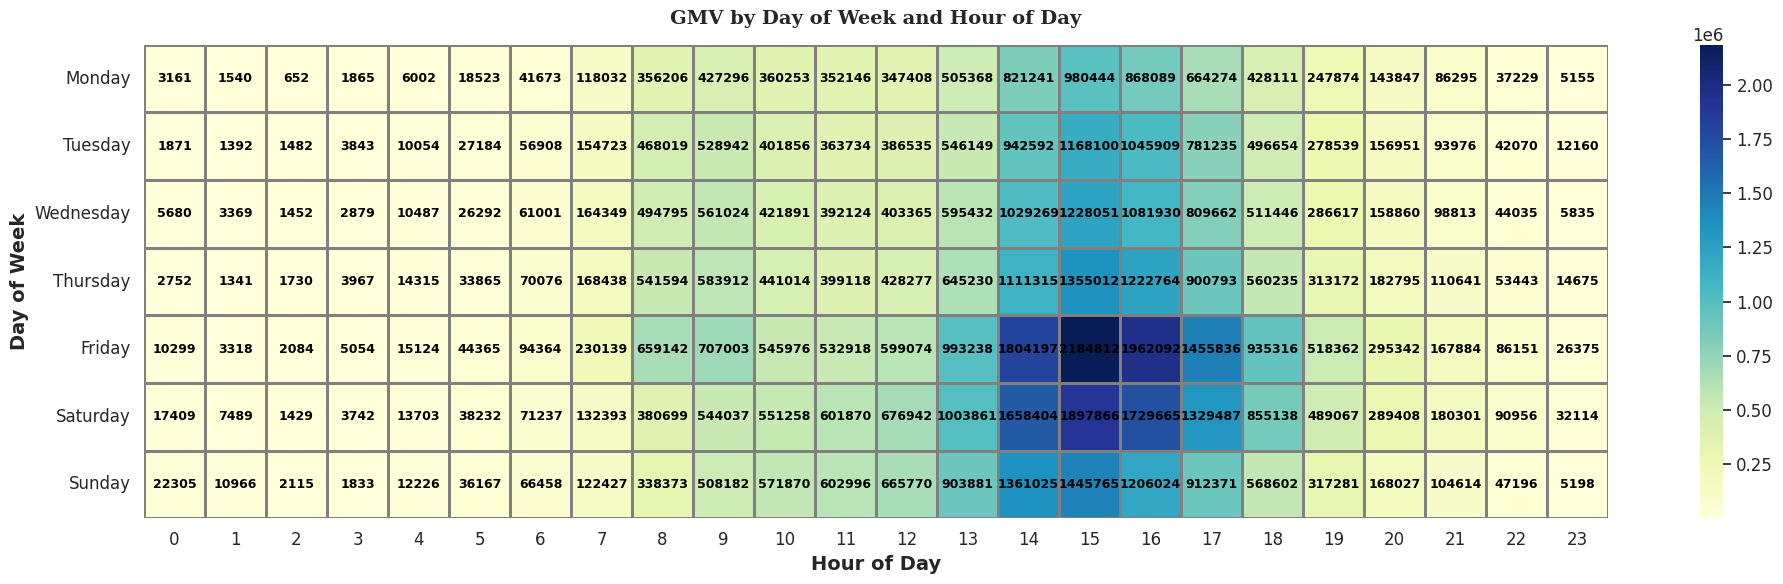

In [ ]:
# Heatmap: GMV by day of week and hour
heatmap_data = df.groupby(['day_of_week', 'hour'])['GMV'].sum().unstack()
# Optional: Reorder days
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(ordered_days)

plt.figure(figsize=(20, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.8, linecolor='gray', annot=True, fmt='.0f', annot_kws={"size": 9, "weight": "bold", "color": "black"})

plt.title('GMV by Day of Week and Hour of Day', fontsize=14, weight='bold', family='serif', pad=15)
plt.xlabel('Hour of Day', fontsize=14, weight='bold')
plt.ylabel('Day of Week', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

### **📌 Heatmap of Orders by Day of Week and Hour**

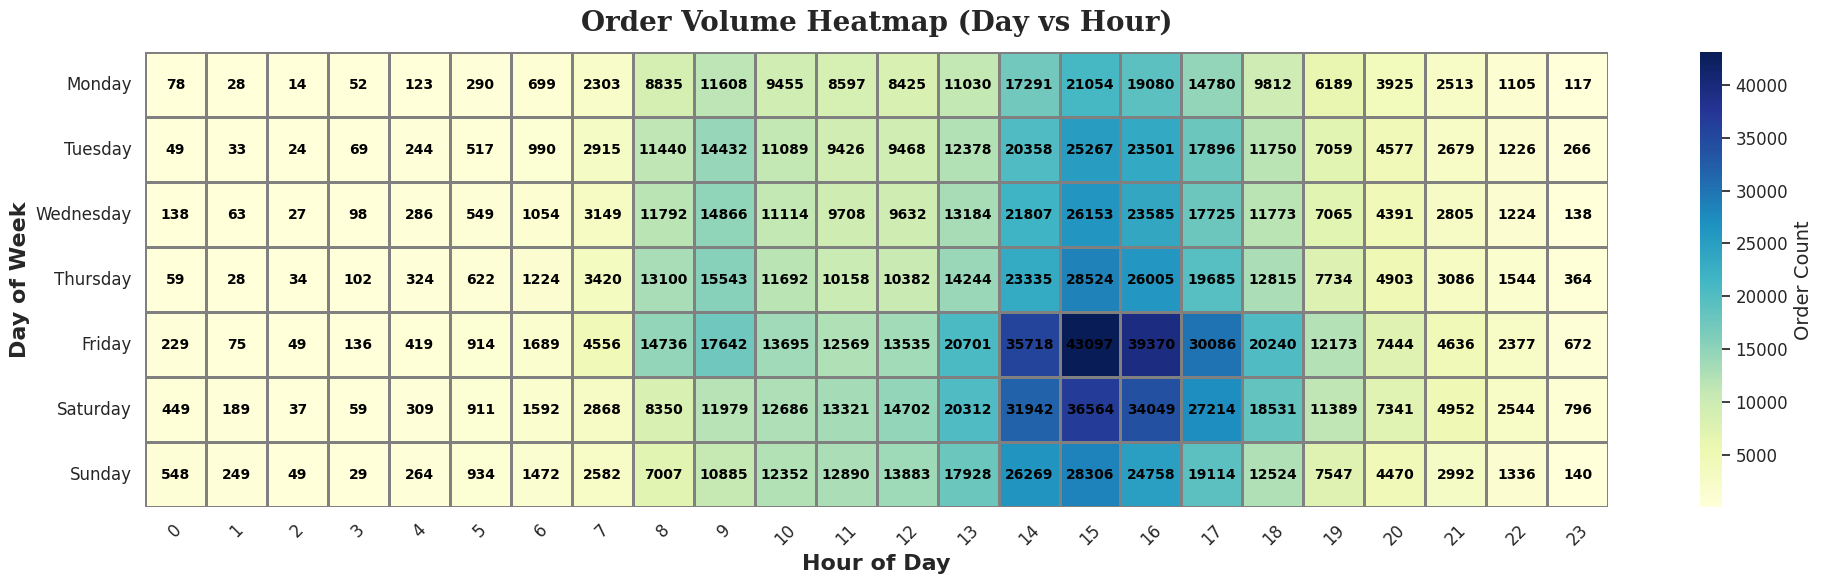

In [ ]:
plt.figure(figsize=(20, 6))
sns.set_style("white")

# Heatmap: GMV by day of week and hour
heatmap_df = df.groupby(['day_of_week', 'hour'])['ORDER_ID'].nunique().unstack().fillna(0)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_df = heatmap_df.reindex(days_order)

# Create heatmap with improved visuals
ax = sns.heatmap(heatmap_df, cmap='YlGnBu', linewidths=0.8, linecolor='gray', annot=True, fmt='.0f', annot_kws={"size": 10, "weight": "bold", "color": "black"}, cbar_kws={'label': 'Order Count'})

# Axis labels and title with improved font size and weight
plt.title("Order Volume Heatmap (Day vs Hour)", fontsize=20, weight='bold', family='serif', pad=15)
plt.xlabel("Hour of Day", fontsize=16, weight='bold')
plt.ylabel("Day of Week", fontsize=16, weight='bold')

# Rotate x-axis ticks for better readability
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# **4. Daily Metrics + 📈 Trend Visuals**

In [ ]:
# Daily metrics
daily_metrics = df.groupby('order_date').agg({'ORDER_ID': 'nunique',
                                              'GUEST_ID': 'nunique',
                                                   'GMV': 'sum',
                                       'NUMBER_OF_ITEMS': 'sum',
                                            'HAS_COUPON': 'mean',
                                          'DELIVERY_FEE': 'sum'}).rename(columns={'ORDER_ID':'num_orders','GUEST_ID':'num_guests','HAS_COUPON':'coupon_rate'})
daily_metrics['avg_order_value'] = daily_metrics['GMV']/daily_metrics['num_orders']

### **Monthly Aggregation Overview**

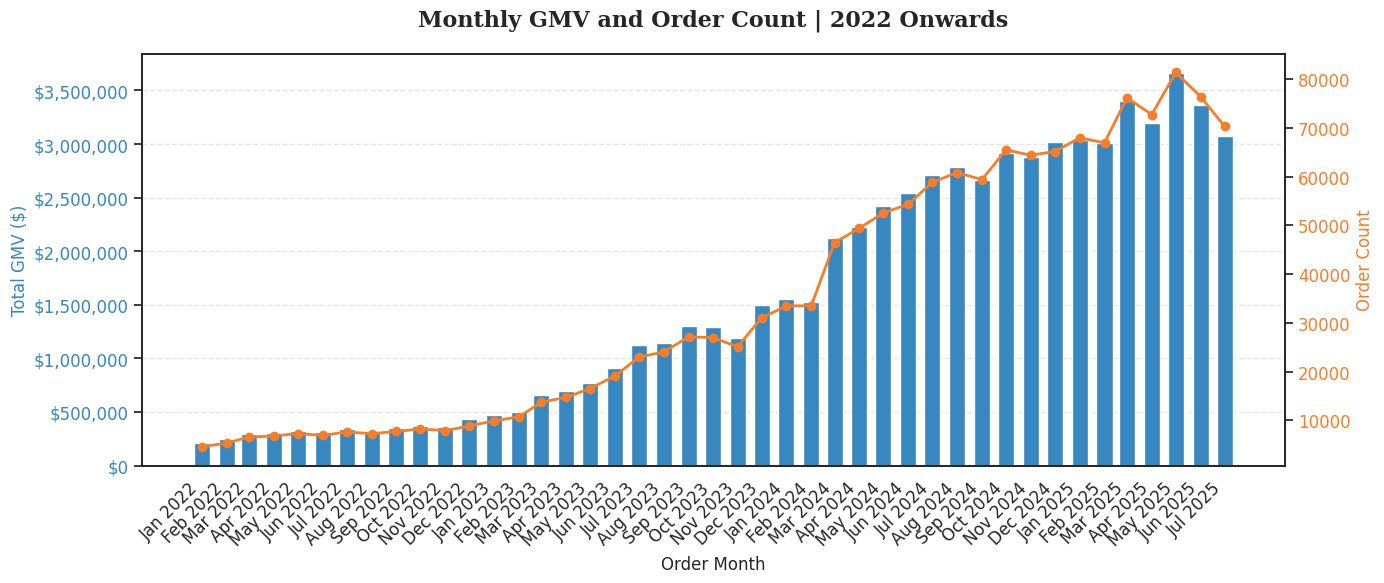

In [ ]:
# Monthly aggregation of GMV and Orders

# Filter data from 2022 onwards
df['order_month'] = pd.to_datetime(df['ORDER_CREATED_AT_PT']).dt.to_period('M').dt.to_timestamp()
monthly = df[df['order_month'] >= '2022-01-01'].groupby('order_month').agg(GMV=('GMV', 'sum'), order_count=('ORDER_ID', 'count')).reset_index()

# Set colors
gmv_color = sns.color_palette("Blues", 8)[5]       # Soft blue
orders_color = sns.color_palette("Oranges", 8)[4]  # Soft orange

# Plot with dual axes
fig, ax1 = plt.subplots(figsize=(14, 6))

# Bar plot for GMV (left axis)
ax1.bar(monthly['order_month'], monthly['GMV'], color=gmv_color, width=20, label='GMV')
ax1.set_ylabel('Total GMV ($)', color=gmv_color, fontsize=12)
ax1.tick_params(axis='y', labelcolor=gmv_color)
ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Line plot for order count (right axis)
ax2 = ax1.twinx()
ax2.plot(monthly['order_month'], monthly['order_count'], color=orders_color, marker='o', linewidth=2, label='Order Count')
ax2.set_ylabel('Order Count', color=orders_color, fontsize=12)
ax2.tick_params(axis='y', labelcolor=orders_color)

# Formatting
ax1.set_xlabel('Order Month', fontsize=12)
ax1.set_xticks(monthly['order_month'])
ax1.set_xticklabels(monthly['order_month'].dt.strftime('%b %Y'), rotation=45, ha='right')

# Title and grid
plt.title('Monthly GMV and Order Count | 2022 Onwards', fontsize=16, weight='bold', family='serif', pad=20)
ax1.grid(True, axis='y', linestyle='--', alpha=0.5)

# Tight layout
fig.tight_layout()
plt.show()

### 📊 **Daily GMV and Order Trends**

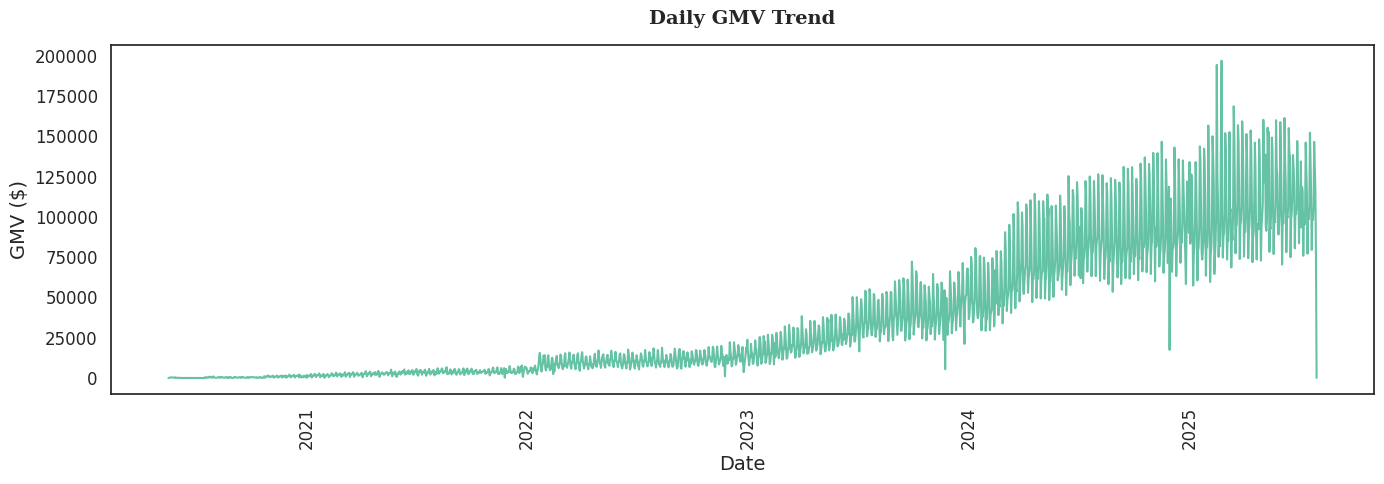

In [ ]:
plt.figure(figsize=(14,5))
sns.lineplot(data=daily_metrics, x='order_date', y='GMV')
plt.title('Daily GMV Trend', fontsize=14, family='serif', weight='bold', pad=15)
plt.ylabel('GMV ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

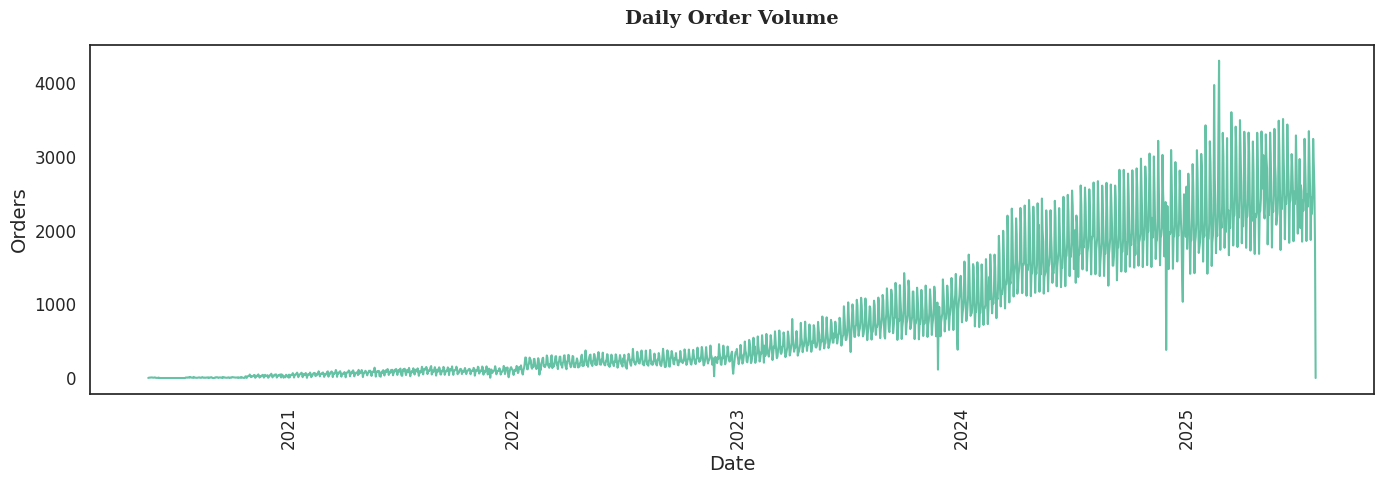

In [ ]:
plt.figure(figsize=(14,5))
sns.lineplot(data=daily_metrics, x='order_date', y='num_orders')
plt.title('Daily Order Volume', fontsize=14, family='serif', weight='bold', pad=15)
plt.ylabel('Orders')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2735748974.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_metrics_filtered['GMV_rolling'] = daily_metrics_filtered['GMV'].rolling(7).mean()
/tmp/ipython-input-2735748974.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_metrics_filtered['orders_rolling'] = daily_metrics_filtered['num_orders'].rolling(7).mean()


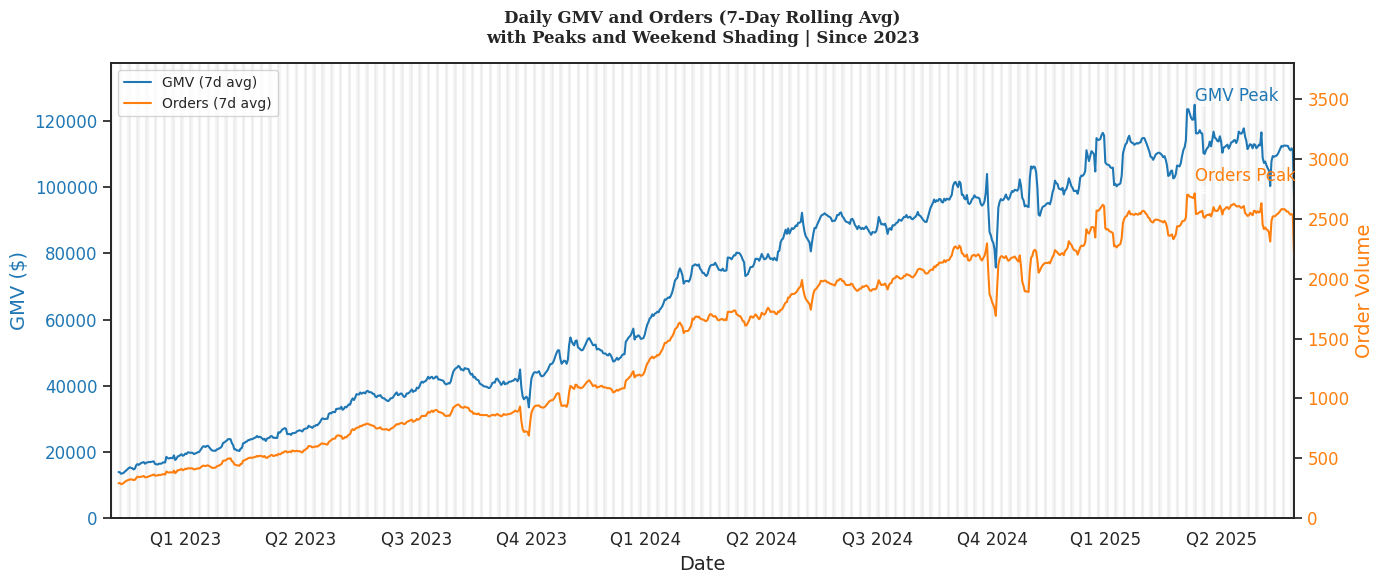

In [ ]:
# Ensure index is datetime
daily_metrics.index = pd.to_datetime(daily_metrics.index)

# Filter date range from 2023-01-01 to today
start_date = pd.Timestamp('2023-01-01')
end_date = pd.Timestamp.today()

daily_metrics_filtered = daily_metrics.loc[(daily_metrics.index >= start_date) & (daily_metrics.index <= end_date)]

# Now compute rolling averages on filtered data
daily_metrics_filtered['GMV_rolling'] = daily_metrics_filtered['GMV'].rolling(7).mean()
daily_metrics_filtered['orders_rolling'] = daily_metrics_filtered['num_orders'].rolling(7).mean()

# Use daily_metrics_filtered for plotting instead of daily_metrics
fig, ax1 = plt.subplots(figsize=(14, 6))

color_gmv = '#1f77b4'
ax1.set_xlabel('Date')
ax1.set_ylabel('GMV ($)', color=color_gmv)
sns.lineplot(x=daily_metrics_filtered.index, y=daily_metrics_filtered['GMV_rolling'], ax=ax1, label='GMV (7d avg)', color=color_gmv, legend=False)
ax1.tick_params(axis='y', labelcolor=color_gmv)

ax2 = ax1.twinx()
color_orders = '#ff7f0e'
ax2.set_ylabel('Order Volume', color=color_orders)
sns.lineplot(x=daily_metrics_filtered.index, y=daily_metrics_filtered['orders_rolling'], ax=ax2, label='Orders (7d avg)', color=color_orders, legend=False)
ax2.tick_params(axis='y', labelcolor=color_orders)

ax1.set_ylim(0, daily_metrics_filtered['GMV_rolling'].max() * 1.1)
ax2.set_ylim(0, daily_metrics_filtered['orders_rolling'].max() * 1.4)

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
def quarter_formatter(x, pos=None):
    dt = mdates.num2date(x)
    quarter = (dt.month - 1) // 3 + 1
    return f"Q{quarter} {dt.year}"
ax1.xaxis.set_major_formatter(FuncFormatter(quarter_formatter))
plt.xticks(rotation=45)

gmv_peak = daily_metrics_filtered['GMV_rolling'].idxmax()
order_peak = daily_metrics_filtered['orders_rolling'].idxmax()

ax1.annotate('GMV Peak', xy=(gmv_peak, daily_metrics_filtered.loc[gmv_peak, 'GMV_rolling']), xytext=(gmv_peak, daily_metrics_filtered.loc[gmv_peak, 'GMV_rolling'] + 1000),
    arrowprops=dict(facecolor=color_gmv, arrowstyle='->'), color=color_gmv, fontsize=12)

ax2.annotate('Orders Peak', xy=(order_peak, daily_metrics_filtered.loc[order_peak, 'orders_rolling']),
    xytext=(order_peak, daily_metrics_filtered.loc[order_peak, 'orders_rolling'] + 100), arrowprops=dict(facecolor=color_orders, arrowstyle='->'), color=color_orders, fontsize=12)

for day in pd.date_range(daily_metrics_filtered.index.min(), daily_metrics_filtered.index.max()):
    if day.weekday() in [5, 6]:
        ax1.axvspan(day, day + timedelta(days=1), color='gray', alpha=0.05)

plt.title('Daily GMV and Orders (7-Day Rolling Avg)\nwith Peaks and Weekend Shading | Since 2023', fontsize=12, family='serif', weight='bold', pad=15)
ax1.set_xlim(daily_metrics_filtered.index.min(), daily_metrics_filtered.index.max())
fig.tight_layout()
# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
# Show both legends as one at top-left
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=10, frameon=True)
plt.show()

**Enhancements to the above:**

✅ 7-day rolling avg	| Smoother trend lines

📍 Peak point labels | Call out highs in GMV and Orders

🗓 Weekend shading | Identify demand dips/spikes on weekends

**Further Additions:**

📅 Promotion period overlays (e.g., gray or green bands)

🎉 Holiday or Event markers (e.g., vertical lines with labels)

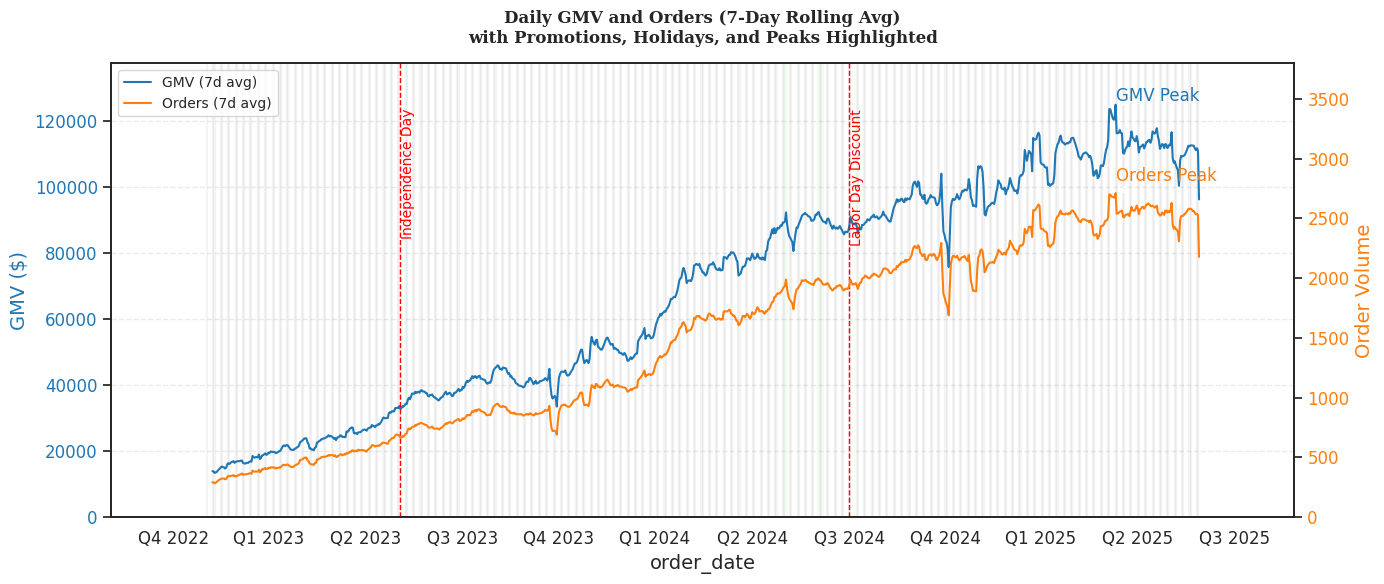

In [ ]:
# Example: Promotion periods (tuples of start and end dates)
promo_periods = [('2024-07-01', '2024-07-04'), ('2024-08-01', '2024-08-07')]
# Example: Holidays or events
events = {'2023-07-04': 'Independence Day', '2024-09-01': 'Labor Day Discount'}

# Define quarterly formatter function
def quarter_formatter(x, pos=None):
    dt = mdates.num2date(x)
    quarter = (dt.month - 1) // 3 + 1
    return f"Q{quarter} {dt.year}"

fig, ax1 = plt.subplots(figsize=(14, 6))
color_gmv = '#1f77b4'
color_orders = '#ff7f0e'

# Plot GMV rolling average - use index as x-axis
sns.lineplot(x=daily_metrics_filtered.index, y='GMV_rolling', data=daily_metrics_filtered, ax=ax1, label='GMV (7d avg)', color=color_gmv, linewidth=1.5, legend=False)
ax1.set_ylabel('GMV ($)', color=color_gmv)
ax1.tick_params(axis='y', labelcolor=color_gmv)
ax1.grid(axis='y', linestyle='--', alpha=0.4)

# Plot orders rolling average on secondary y-axis
ax2 = ax1.twinx()
sns.lineplot(x=daily_metrics_filtered.index, y='orders_rolling', data=daily_metrics_filtered, ax=ax2, label='Orders (7d avg)', color=color_orders, linewidth=1.5, legend=False)
ax2.set_ylabel('Order Volume', color=color_orders)
ax2.tick_params(axis='y', labelcolor=color_orders)
ax2.grid(False)

# Set axis limits
ax1.set_ylim(0, daily_metrics_filtered['GMV_rolling'].max() * 1.1)
ax2.set_ylim(0, daily_metrics_filtered['orders_rolling'].max() * 1.4)

# Format X-axis ticks and labels for quarters
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax1.xaxis.set_major_formatter(FuncFormatter(quarter_formatter))
plt.xticks(rotation=45)

# Combine legends from both axes and place at upper left inside plot
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10, frameon=True)

# Annotate peaks
gmv_peak_date = daily_metrics_filtered['GMV_rolling'].idxmax()
order_peak_date = daily_metrics_filtered['orders_rolling'].idxmax()

ax1.annotate('GMV Peak', xy=(gmv_peak_date, daily_metrics_filtered.loc[gmv_peak_date, 'GMV_rolling']), xytext=(gmv_peak_date, daily_metrics_filtered.loc[gmv_peak_date, 'GMV_rolling'] + 1000),
    arrowprops=dict(facecolor=color_gmv, arrowstyle='->'), color=color_gmv, fontsize=12)

ax2.annotate('Orders Peak', xy=(order_peak_date, daily_metrics_filtered.loc[order_peak_date, 'orders_rolling']), xytext=(order_peak_date, daily_metrics_filtered.loc[order_peak_date, 'orders_rolling'] + 100),
    arrowprops=dict(facecolor=color_orders, arrowstyle='->'), color=color_orders, fontsize=12)

# Shade weekends
for day in pd.date_range(daily_metrics_filtered.index.min(), daily_metrics_filtered.index.max()):
    if day.weekday() in [5, 6]:  # Saturday or Sunday
        ax1.axvspan(day, day + pd.Timedelta(days=1), color='gray', alpha=0.05)

# Highlight promotion periods
for start, end in promo_periods:
    ax1.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='lightgreen', alpha=0.07)

# Mark events with vertical lines and labels
for date_str, label in events.items():
    event_date = pd.to_datetime(date_str)
    ax1.axvline(event_date, color='red', linestyle='--', linewidth=1)
    ax1.text(event_date + pd.Timedelta(days=0.15), ax1.get_ylim()[1] * 0.9, label, color='red', fontsize=10, rotation=90, verticalalignment='top')

# Set title and x-axis limits with some padding
plt.title('Daily GMV and Orders (7-Day Rolling Avg)\nwith Promotions, Holidays, and Peaks Highlighted', fontsize=12, family='serif', weight='bold', pad=15)
ax1.set_xlim(daily_metrics_filtered.index.min() - pd.Timedelta(days=90), daily_metrics_filtered.index.max() + pd.Timedelta(days=90))

fig.tight_layout()
plt.show()

## **Summary of Features**

🔄 **7-day smoothing** | Smooth trend lines for GMV & orders

🔺 **Peak annotations**	| Labels for max points

📆 **Promotion overlays**	| Highlight key business periods

🎉 **Event markers** | Add context with holiday/campaign labels

# **5. Monthly Metrics (GMV & Orders) + 📈 Trend Visuals**

**Insights to look for:**

- Are orders growing month over month?

- Is GMV rising but AOV dropping (smaller carts)?

- Are unique guests growing or stalling?

In [ ]:
monthly = df.groupby('order_month').agg({'GMV': 'sum', 'ORDER_ID': 'nunique', 'GUEST_ID': 'nunique'}).rename(columns={'ORDER_ID': 'orders', 'GUEST_ID': 'unique_guests'})

# Compute Average Order Value
monthly['AOV'] = monthly['GMV']/monthly['orders']

In [ ]:
#Run print(monthly.head()) before plotting to confirm it’s populated and index is datetime.
print(monthly.head())

                 GMV  orders  unique_guests   AOV
order_month                                      
2020-05-01   3514.81      88             78 39.94
2020-06-01    560.35      14             14 40.02
2020-07-01   6476.29     118            112 54.88
2020-08-01  10756.02     196            183 54.88
2020-09-01   9958.36     196            173 50.81


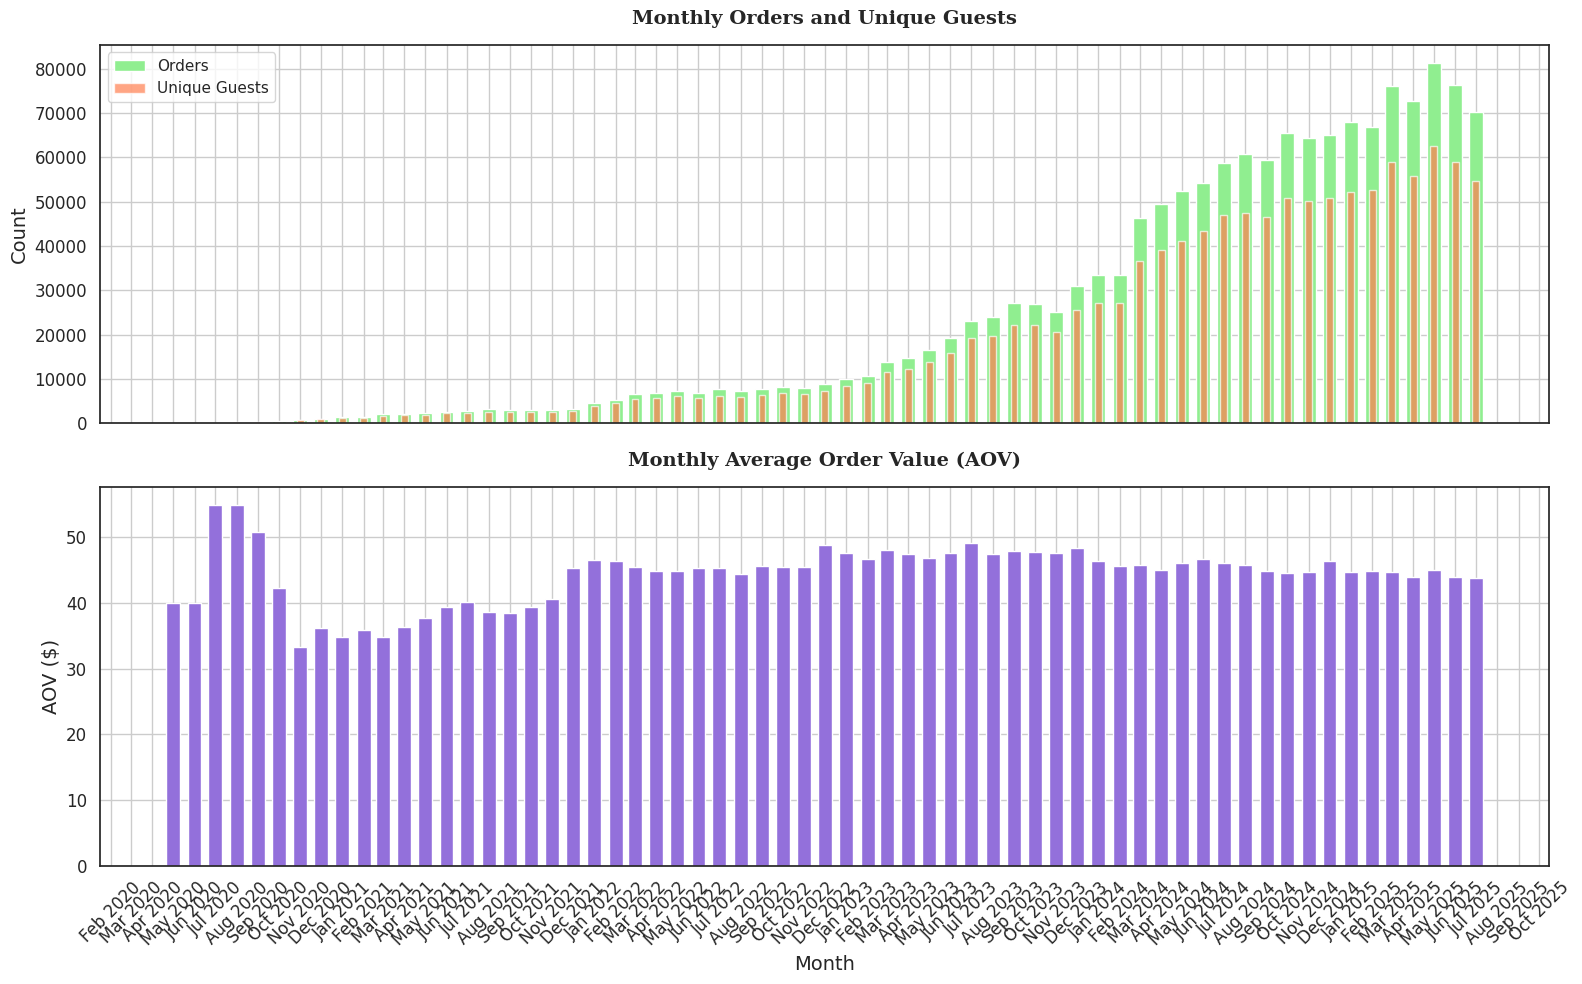

In [ ]:
# Ensure index is datetime for plotting
if isinstance(monthly.index, pd.PeriodIndex):
    monthly.index = monthly.index.to_timestamp()

# Optional: sort and check for missing data
monthly = monthly.sort_index()
monthly = monthly.fillna(0)

# Setup subplots
fig, axs = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Plot 1: Orders and Unique Guests
axs[0].bar(monthly.index, monthly['orders'], color='lightgreen', label='Orders', width=20)
axs[0].bar(monthly.index, monthly['unique_guests'], color='coral', alpha=0.7, label='Unique Guests', width=10)
axs[0].set_title('Monthly Orders and Unique Guests', fontsize=14, weight='bold', family='serif', pad=15)
axs[0].set_ylabel('Count')
axs[0].legend()
axs[0].grid(True)

# Plot 2: AOV
axs[1].bar(monthly.index, monthly['AOV'], color='mediumpurple', width=20)
axs[1].set_title('Monthly Average Order Value (AOV)', fontsize=14, weight='bold', family='serif', pad=15)
axs[1].set_ylabel('AOV ($)')
axs[1].set_xlabel('Month')
axs[1].grid(True)

# Format x-axis for months
axs[1].xaxis.set_major_locator(mdates.MonthLocator())
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Rotate ticks
for ax in axs:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# **6. Guest Behavior Analysis**

In [ ]:
guest_orders = df.groupby('GUEST_ID')['ORDER_ID'].nunique()
repeat_rate = (guest_orders > 1).mean()
print(f"Repeat Guest Rate: {repeat_rate:.2%}")

Repeat Guest Rate: 30.36%


**Step 1: Understand the distribution**

Top 10 Guests by GMV:
GUEST_ID
7678eb92ddee11e9c822c26426a14bb8   14828.06
dd78c85d7326770ee96cda50e3cf7039   13608.25
7fb99f07499813d887257772a00102bb   12849.60
155758cf75e88759f4d3565891078e23   10055.58
1ff4492adeaf49f8c458ecdb5e8c8801    9098.57
d82b6faf04400d04e0905debc213c690    8974.14
6844e6f52aba752c24f2555010aa48f0    8780.15
c6755c7a1ac6d7f3ef39933968119609    8594.06
1d178cde2c86aa925d579ce48d80dc3d    8332.44
fbbeacd57a6d725bcffb13af6b0923aa    8092.86
Name: GMV, dtype: float64


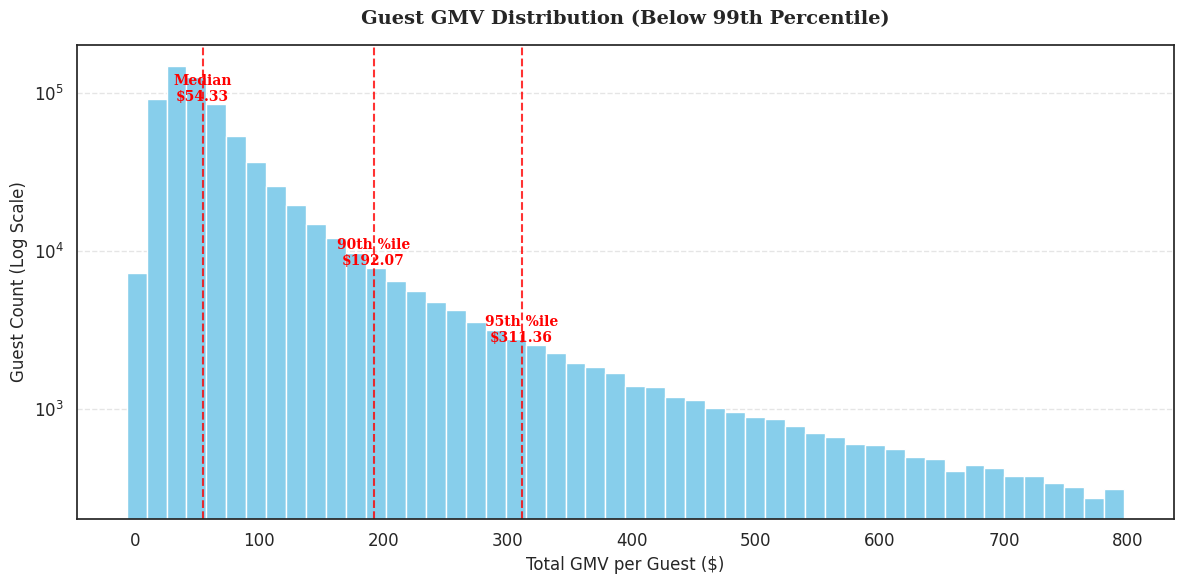

In [ ]:
# Group GMV by guest
guest_gmv = df.groupby('GUEST_ID')['GMV'].sum()

#Top Guests Table
top_guests = guest_gmv.sort_values(ascending=False).head(10)
print("Top 10 Guests by GMV:")
print(top_guests)

# Descriptive stats
desc = guest_gmv.describe(percentiles=[.5, .9, .95, .99])

# Filter for plotting (under 99th percentile)
gmv_threshold = desc['99%']
filtered_gmv = guest_gmv[guest_gmv <= gmv_threshold]

# Plot histogram
plt.figure(figsize=(12, 6))
counts, bins, patches = plt.hist(filtered_gmv, bins=50, color='skyblue', edgecolor='white', log=True)

# Titles & axis labels
plt.title('Guest GMV Distribution (Below 99th Percentile)', fontsize=14, weight='bold', family='serif', pad=15)
plt.xlabel('Total GMV per Guest ($)', fontsize=12)
plt.ylabel('Guest Count (Log Scale)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5, axis='y')

# Add percentile lines and annotations at actual heights
for percentile, label in zip([0.5, 0.9, 0.95], ['Median', '90th %ile', '95th %ile']):
    value = guest_gmv.quantile(percentile)
    # Find closest bin index
    bin_idx = (np.abs(bins - value)).argmin()
    y_value = counts[bin_idx] if bin_idx < len(counts) else 1
    plt.axvline(value, color='red', linestyle='--', alpha=0.8)
    plt.text(value, y_value + 2, f'{label}\n${value:.2f}', color='red', fontsize=10, ha='center', va='bottom', fontweight='bold', family='serif')

plt.tight_layout()
plt.show()

**Step 2: Cap/clip outliers**

In [ ]:
# Filter out top 1% outliers for better histogram readability
threshold = guest_gmv.quantile(0.99)
guest_gmv_filtered = guest_gmv[guest_gmv <= threshold]

In [ ]:
print(guest_gmv_filtered.describe())

count   691045.00
mean        85.89
std         98.98
min         -6.85
25%         33.49
50%         53.82
75%         93.94
max        796.86
Name: GMV, dtype: float64


In [ ]:
print(guest_gmv_filtered.shape)
print(guest_gmv_filtered.head())
print(guest_gmv_filtered.describe())

(691045,)
GUEST_ID
00001eb7e5c6e13a599c13a43b897733   138.57
0000225c4150628309170c6fa23b65bd    28.35
000054893a9e117ee296621a7b35af64   111.00
0000575311f86080e9b4586ad4a51f21    30.61
00006d2f5c6c3994f34a171f67c215bf    31.57
Name: GMV, dtype: float64
count   691045.00
mean        85.89
std         98.98
min         -6.85
25%         33.49
50%         53.82
75%         93.94
max        796.86
Name: GMV, dtype: float64


In [ ]:
print("Filtered GMV count:", len(guest_gmv_filtered))
print(guest_gmv_filtered.describe())
print("Min value:", guest_gmv_filtered.min())
print("Max value:", guest_gmv_filtered.max())

Filtered GMV count: 691045
count   691045.00
mean        85.89
std         98.98
min         -6.85
25%         33.49
50%         53.82
75%         93.94
max        796.86
Name: GMV, dtype: float64
Min value: -6.85
Max value: 796.86


**Step 3: Plot**

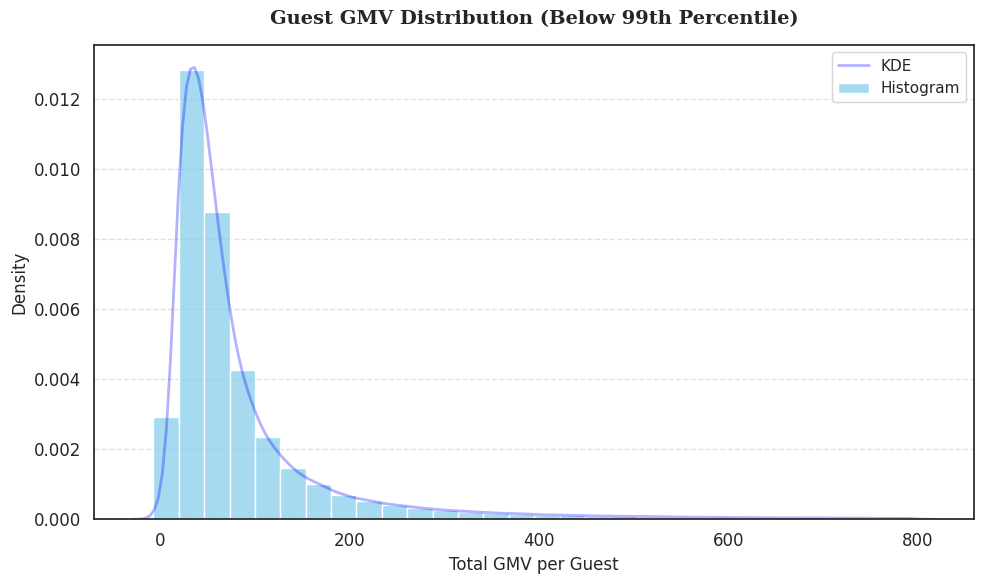

In [ ]:
plt.figure(figsize=(10, 6))

# Histogram with density scaling (so it aligns better with KDE)
sns.histplot(guest_gmv_filtered, bins=30, color='skyblue', edgecolor='white', stat='density', label='Histogram')

# KDE plot overlay
sns.kdeplot(guest_gmv_filtered, color='blue', alpha=0.3, linewidth=2, label='KDE')

# Use linear y-axis scale for better KDE visibility
plt.yscale('linear')

plt.title("Guest GMV Distribution (Below 99th Percentile)", fontsize=14, weight='bold', family='serif', pad=15)
plt.xlabel("Total GMV per Guest", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6, axis='y')
plt.legend()
plt.tight_layout()
plt.show()

## **Guest Behavior Analysis | Pareto Analysis: Cumulative % Line**

This shows how much total GMV is contributed by the top % of guests, visualizing the 80/20 rule (or whatever % pattern exists in our data)

**Output Explanation:**

- Blue bars show how many guests spend at each GMV range (log-scaled count).

- Red line shows what % of total GMV is contributed by the top % of guests.

- Dashed lines show the "80/20" crossover point.

**This can answer questions like:**

- Do 20% of guests drive 80% of GMV?

- Where should retention efforts focus?

**Probable insight:**

- High concentration of GMV among a small % of guests?

- Opportunity to identify and target power users.

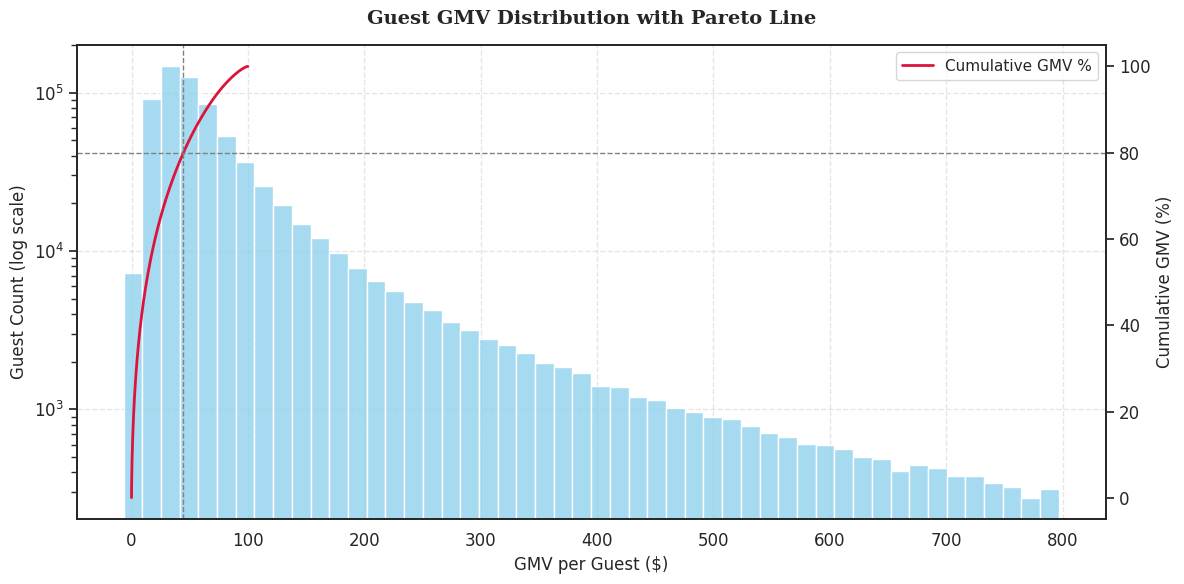

In [ ]:
# --- Group by Guest ---
guest_gmv = df.groupby('GUEST_ID')['GMV'].sum().sort_values(ascending=False)

# --- Create Pareto Data ---
pareto_df = guest_gmv.reset_index(drop=True).to_frame(name='GMV')
pareto_df['Cumulative_GMV'] = pareto_df['GMV'].cumsum()
pareto_df['Cumulative_Percent'] = pareto_df['Cumulative_GMV']/pareto_df['GMV'].sum()*100
pareto_df['Guest_Rank'] = np.arange(1, len(pareto_df)+1)
pareto_df['Guest_Percent'] = pareto_df['Guest_Rank']/len(pareto_df)*100

# --- Plot: Histogram + Cumulative Line ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Histogram of GMV (filtered for better readability)
filtered = guest_gmv[guest_gmv <= guest_gmv.quantile(0.99)]
sns.histplot(filtered, bins=50, ax=ax1, color='skyblue', edgecolor='white')
ax1.set_ylabel('Guest Count (log scale)', fontsize=12)
ax1.set_xlabel('GMV per Guest ($)', fontsize=12)
ax1.set_yscale('log')
ax1.grid(True, linestyle='--', alpha=0.5)

# Twin axis for Pareto Line
ax2 = ax1.twinx()
ax2.plot(pareto_df['Guest_Percent'], pareto_df['Cumulative_Percent'], color='crimson', linewidth=2, label='Cumulative GMV %')
ax2.set_ylabel('Cumulative GMV (%)', fontsize=12)
ax2.axhline(80, color='gray', linestyle='--', lw=1)
ax2.axvline(pareto_df[pareto_df['Cumulative_Percent'] >= 80]['Guest_Percent'].iloc[0], color='gray', linestyle='--', lw=1)

# --- Titles & Labels ---
plt.title("Guest GMV Distribution with Pareto Line", fontsize=14, weight='bold', family='serif', pad=15)
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

**📈 Interpreting the above chart:**

X-axis (Total GMV per Guest (in dollars)):
Buckets of total spend per guest — e.g., $0-10, $10-20, ..., $90-100, etc.

Y-axis (Guest Count) – in log scale:
The number of guests who fall into each spending bucket. Since it's in log scale, even small differences in height can represent large differences in user counts.

**Bars:**
Each bar tells you how many guests spent within a given dollar range in total over the observed period.

**Red dashed vertical lines + annotations:**
These mark key percentiles:

🔸 Median: 50% of guests spent below this amount.

🔸 90th percentile: Top 10% of guests spent more than this.

🔸 95th percentile: Top 5% of guests spent more than this.

**🔍 Key insights:**
Most guests are low spenders.
Since the bulk of the bars are stacked on the left, it shows that the majority of users spend relatively little — this is common in consumer platforms.

**Heavy skew/long tail:**
A few guests spend a lot (e.g., >$200), but they're very rare. These would have been in the top 1% you excluded from this view.

**Median GMV is low:**
Since the median line is far left, most users are low-engagement or casual.

**Opportunity for segmentation | We can define tiers like:**

**Low-value guests** (below median)

**Medium-value guests** (50–90th percentile)

**High-value guests** (90th–99th)

**VIP/power users** (top 1%, which we can analyze separately)


As a growth strategy, to increase revenue, we can consider:

- Increasing frequency or basket size of low-median guests.

- Retaining high-GMV guests with loyalty programs or VIP treatment.

## **Guest Behavior Analysis | Explore heavy users | Top 1% (High-GMV) Guest Analysis | Uncovering VIP behavior**

In [ ]:
# Threshold already defined earlier from guest_gmv.describe()['99%']
high_gmv = guest_gmv[guest_gmv > threshold]
print(f"Top 1% guests contributed ${high_gmv.sum():,.2f} in GMV")

Top 1% guests contributed $9,473,246.19 in GMV


In [ ]:
total_gmv = guest_gmv.sum()
high_gmv = guest_gmv[guest_gmv > threshold]
high_gmv_total = high_gmv.sum()
high_gmv_pct = high_gmv_total / total_gmv * 100

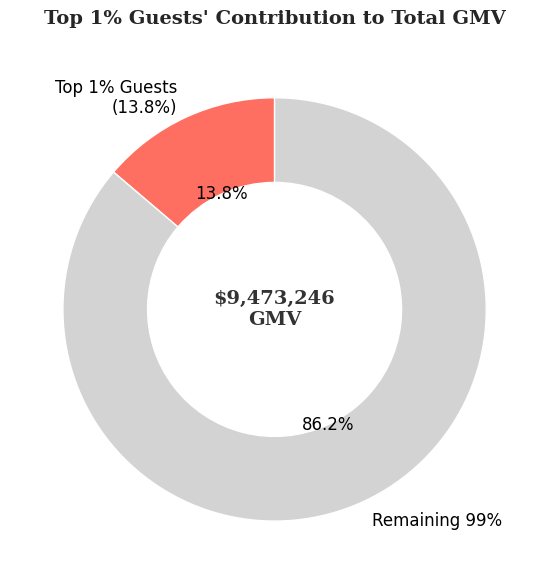

In [ ]:
# Data
sizes = [high_gmv_pct, 100 - high_gmv_pct]
labels = [f'Top 1% Guests\n({high_gmv_pct:.1f}%)', 'Remaining 99%']
colors = ['#FF6F61', '#D3D3D3']

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, textprops=dict(color='black', fontsize=12), wedgeprops=dict(width=0.4, edgecolor='white'))

# Center text
ax.text(0, 0, f"${high_gmv_total:,.0f}\nGMV", ha='center', va='center', fontsize=14, fontweight='bold', family='serif', color='#333333')

plt.title("Top 1% Guests' Contribution to Total GMV", fontsize=14, weight='bold', family='serif', pad=15)
plt.tight_layout()
plt.show()

In [ ]:
print(f"Top 1% guests contributed ${high_gmv_total:,.2f} in GMV ({high_gmv_pct:.1f}% of total GMV)")

Top 1% guests contributed $9,473,246.19 in GMV (13.8% of total GMV)


In [ ]:
# Create a DataFrame to join with original df
vip_guests_df = df[df['GUEST_ID'].isin(high_gmv.index)]

**Basic Stats + Revenue Share**

In [ ]:
# How many orders & GMV from this group
vip_stats = vip_guests_df.agg({'ORDER_ID': 'nunique', 'GUEST_ID': 'nunique', 'GMV': 'sum'})
total_stats = df.agg({'ORDER_ID': 'nunique', 'GUEST_ID': 'nunique', 'GMV': 'sum'})

vip_contribution = (vip_stats/total_stats) * 100
print("Top 1% Guest Contribution (%):\n", vip_contribution)

Top 1% Guest Contribution (%):
 ORDER_ID   12.41
GUEST_ID    1.00
GMV        13.76
dtype: float64


**📊 Visual: AOV & Order Frequency for Top 1%**

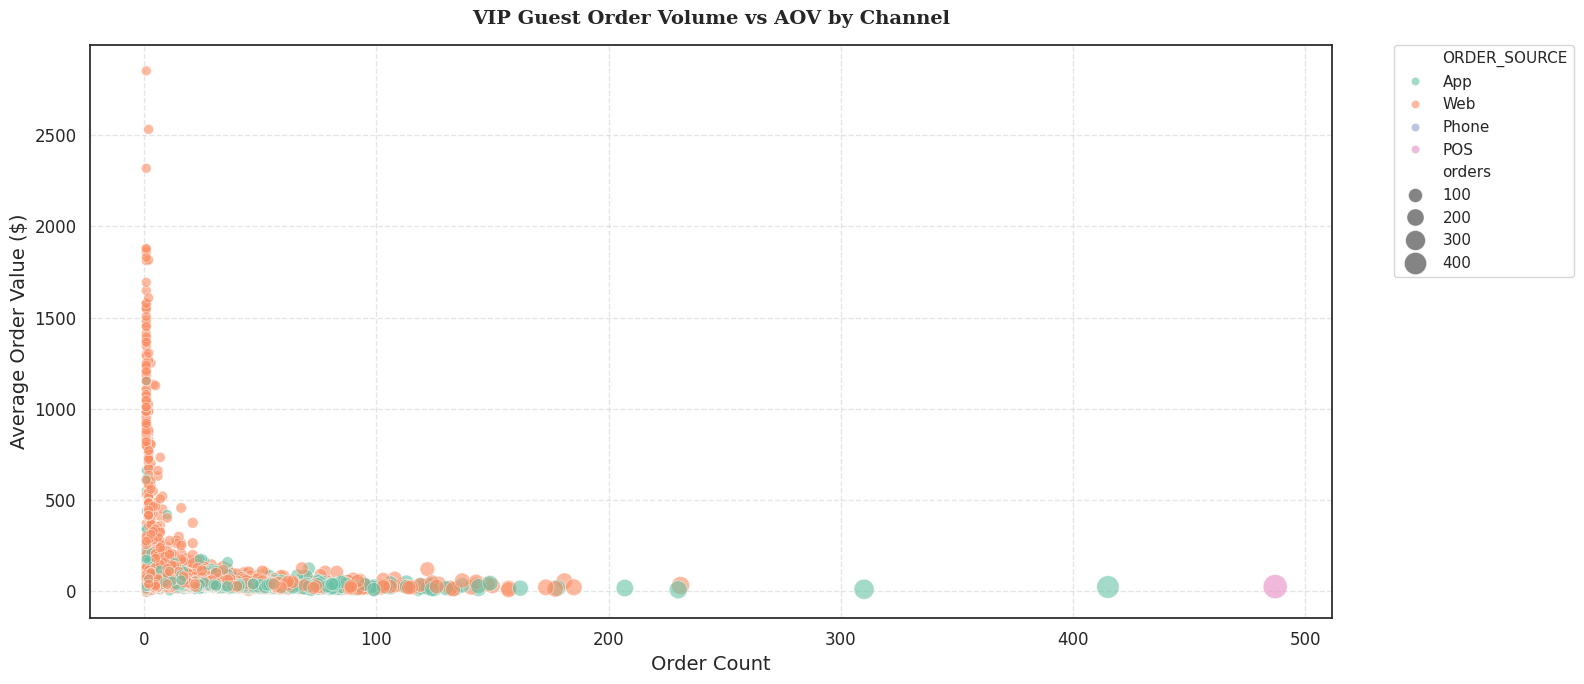

In [ ]:
# Create Average Order Value and order metrics for VIP guests
vip_summary = vip_guests_df.groupby(['GUEST_ID', 'ORDER_SOURCE']).agg(total_gmv=('GMV', 'sum'), orders=('ORDER_ID', 'count')).reset_index()
# Calculate AOV
vip_summary['AOV'] = vip_summary['total_gmv']/vip_summary['orders']

# Plot: AOV vs Orders with hue by ORDER_SOURCE and size by order count
plt.figure(figsize=(16, 7))
sns.scatterplot(data=vip_summary, x='orders', y='AOV', hue='ORDER_SOURCE', size='orders', sizes=(50, 300), alpha=0.6, palette='Set2', edgecolor='white', linewidth=0.5)

# Labels and style
plt.title('VIP Guest Order Volume vs AOV by Channel', fontsize=14, weight='bold', family='serif', pad=15)
plt.xlabel('Order Count')
plt.ylabel('Average Order Value ($)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

# **Insight:**

### **Top spenders are less high-frequency and more high-ticket as we can observe clusters closer to the Y-axis. Order counts are largely concentrated <200**

**Summary Table for VIP Guests - This gives insight into median AOV/order counts**

In [ ]:
print(vip_summary.describe())

       total_gmv  orders     AOV
count    9531.00 9531.00 9531.00
mean      993.94   19.72   82.16
std       786.86   19.90  146.19
min        -4.73    1.00   -4.73
25%       522.85    7.00   37.59
50%       909.96   15.00   52.35
75%      1242.62   27.00   75.62
max     14828.06  487.00 2851.42


**📊 Visual: VIP Contribution to Monthly GMV | Do VIPs drive spikes in revenue? Any drop-off?**

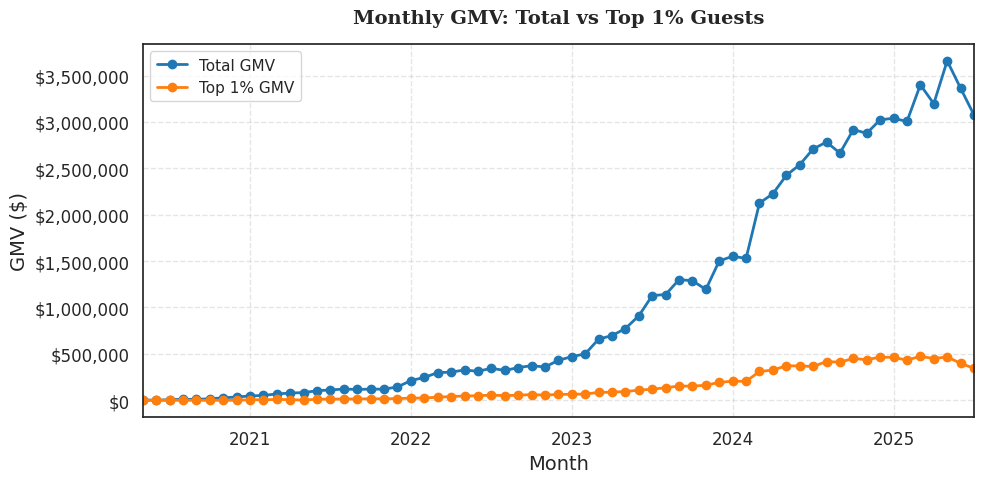

In [ ]:
# Monthly GMV by VIP guests
vip_monthly = vip_guests_df.copy()
vip_monthly['month'] = pd.to_datetime(vip_monthly['ORDER_CREATED_AT_PT']).dt.to_period('M').dt.to_timestamp()
vip_monthly_gmv = vip_monthly.groupby('month')['GMV'].sum()

# Compare with total
df['month'] = pd.to_datetime(df['ORDER_CREATED_AT_PT']).dt.to_period('M').dt.to_timestamp()
total_monthly_gmv = df.groupby('month')['GMV'].sum()

# Combine for plotting
monthly_compare = pd.DataFrame({'Total GMV': total_monthly_gmv, 'Top 1% GMV': vip_monthly_gmv}).fillna(0)

# Plot
ax = monthly_compare.plot(figsize=(10,5), linewidth=2, marker='o', color=['#1f77b4', '#ff7f0e'])

# Fix Y-axis formatting
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Titles and labels
plt.title('Monthly GMV: Total vs Top 1% Guests', fontsize=14, weight='bold', family='serif', pad=15)
plt.ylabel('GMV ($)')
plt.xlabel('Month')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Heatmap: VIP Activity by Day/Hour | Insight: When do VIPs engage the most? Useful for campaign timing**

/tmp/ipython-input-1911077600.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vip_guests_df['day'] = pd.to_datetime(vip_guests_df['ORDER_CREATED_AT_PT']).dt.day_name()
/tmp/ipython-input-1911077600.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vip_guests_df['hour'] = pd.to_datetime(vip_guests_df['ORDER_CREATED_AT_PT']).dt.hour


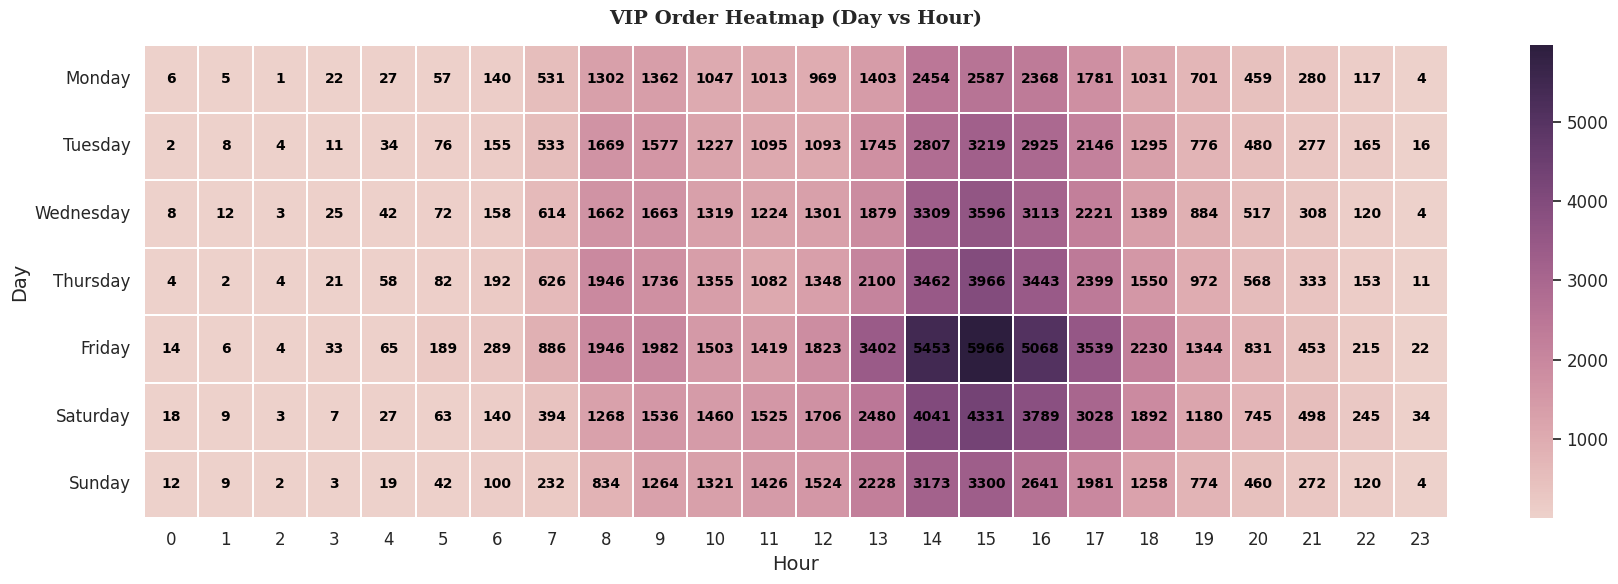

In [ ]:
vip_guests_df['day'] = pd.to_datetime(vip_guests_df['ORDER_CREATED_AT_PT']).dt.day_name()
vip_guests_df['hour'] = pd.to_datetime(vip_guests_df['ORDER_CREATED_AT_PT']).dt.hour

heatmap_data = vip_guests_df.groupby(['day', 'hour'])['ORDER_ID'].count().unstack().fillna(0)
# Reorder days
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(days_order)

plt.figure(figsize=(18,6))
sns.heatmap(heatmap_data, cmap=sns.cubehelix_palette(as_cmap=True), linewidths=0.3, annot=True, fmt='.0f', annot_kws={"size": 10, "weight": "bold", "color": "black"})
plt.title('VIP Order Heatmap (Day vs Hour)', fontsize=14, family='serif', weight='bold', pad=15)
plt.xlabel('Hour')
plt.ylabel('Day')
plt.tight_layout()
plt.show()

## **Metric & allied questions**

💰 Revenue Contribution	| What % of total GMV is from top 1%?

🧾 Order Behavior	| Do they place frequent orders or fewer high-value ones?

⏰ Timing	| When are they most active?

🔁 Repeat Rates	| Are they loyal or one-time spenders?

📈 Monthly Trends	| Are they consistent or seasonal?

📍 Channels	| Which ORDER_SOURCE, DELIVERY_TYPE, or COUPON_TYPE do they prefer?

### **Color Bins by Engagement Tier (user/team-defined)**

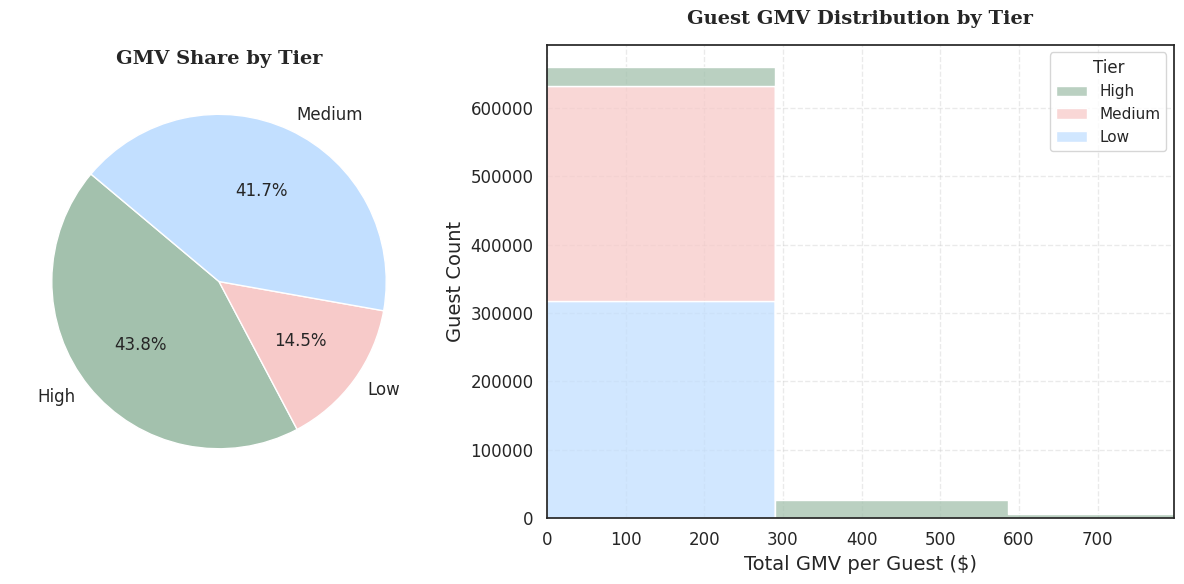

In [ ]:
# Define tiers
def assign_tier(gmv):
    if gmv < 50:
        return 'Low'
    elif gmv < 200:
        return 'Medium'
    else:
        return 'High'

# Create DataFrame with Tier
guest_gmv_tiers = guest_gmv.to_frame().copy()
guest_gmv_tiers['Tier'] = guest_gmv_tiers['GMV'].apply(assign_tier)

# Define soft pastel colors manually
soft_colors = ['#A3C1AD', '#F7CAC9', '#C2DFFF']  # Light green, pink, soft blue

# Setup side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 1.5]})

# --- Left plot: Pie chart ---
tier_gmv_share = guest_gmv_tiers.groupby('Tier')['GMV'].sum()
axes[0].pie(tier_gmv_share, labels=tier_gmv_share.index, autopct='%1.1f%%', colors=soft_colors, startangle=140, wedgeprops={'edgecolor': 'white'})
axes[0].set_title('GMV Share by Tier', fontsize=14, weight='bold', family='serif')

# --- Right plot: Histogram ---
sns.histplot(data=guest_gmv_tiers, x='GMV', hue='Tier', bins=50, palette=soft_colors, multiple='stack', edgecolor='white', element='step', ax=axes[1])

axes[1].set_title('Guest GMV Distribution by Tier', fontsize=14, weight='bold', family='serif', pad=15)
axes[1].set_xlabel('Total GMV per Guest ($)')
axes[1].set_ylabel('Guest Count')
axes[1].set_xlim(0, guest_gmv.quantile(0.99))  # Remove top 1% outliers
axes[1].grid(True, linestyle='--', alpha=0.4)

# Layout
plt.tight_layout()
plt.show()

📊 **Guest Spend Distribution**

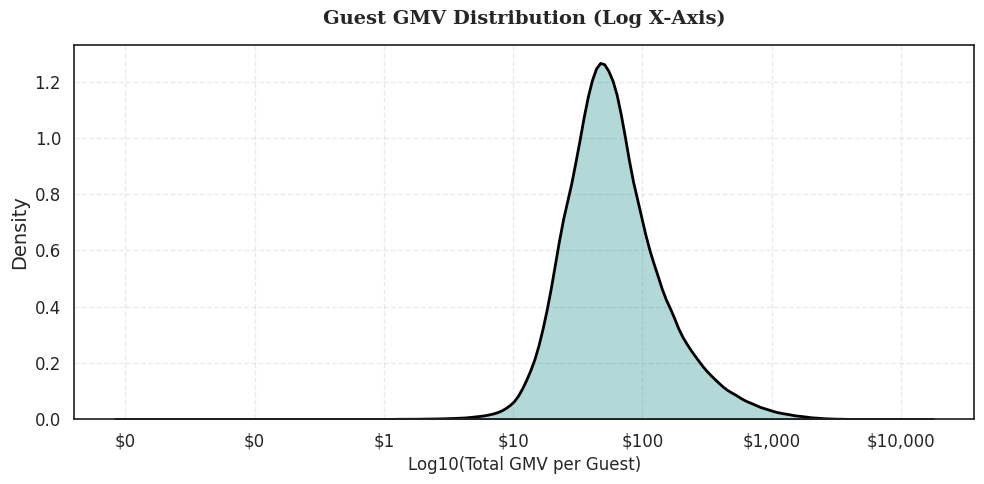

In [ ]:
guest_gmv_nonzero = guest_gmv[guest_gmv > 0]
log_data = np.log10(guest_gmv_nonzero)

plt.figure(figsize=(10, 5))
sns.kdeplot(log_data, fill=True, color='teal', alpha=0.3, linewidth=2, edgecolor='black')
# Labels and formatting
plt.xlabel("Log10(Total GMV per Guest)", fontsize=12)
plt.title("Guest GMV Distribution (Log X-Axis)", fontsize=14, weight='bold', family='serif', pad=15)
plt.grid(True, linestyle='--', alpha=0.4)

# Format x-axis to show actual dollar values (log-transformed)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${10**x:,.0f}"))

plt.tight_layout()
plt.show()

**Creating a Pareto chart for our Guest GMV distribution with:**

- Bars showing GMV per guest (sorted descending)

- A cumulative percentage line for the 80/20 rule

- Color coding bins by engagement tiers (e.g., top 20%, middle, rest)

In [ ]:
# Make sure it's sorted and indexed correctly
guest_gmv = guest_gmv.sort_values(ascending=False)
guest_gmv.index = range(len(guest_gmv))  # reset index to integer for plotting

# Calculate cumulative sum and cumulative percentage
cumulative_gmv = guest_gmv.cumsum()
total_gmv = guest_gmv.sum()
cumulative_pct = cumulative_gmv/total_gmv * 100

# Create tiers for color coding - Top 20% guests by GMV
threshold_80 = guest_gmv.quantile(0.8)
tiers = pd.cut(guest_gmv, bins=[-np.inf, threshold_80, np.inf], labels=['Bottom 80%', 'Top 20%'])

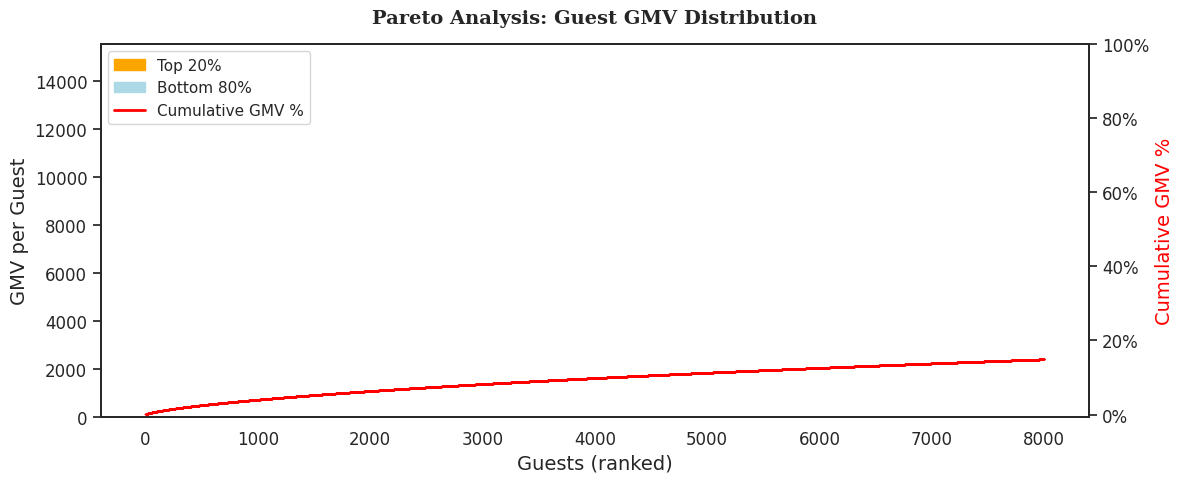

In [ ]:
N = 8000
guest_gmv_small = guest_gmv.iloc[:N].reset_index(drop=True)
cumulative_pct_small = cumulative_pct.iloc[:N].reset_index(drop=True)
tiers_small = tiers.iloc[:N].reset_index(drop=True)

# Plot the Pareto chart
fig, ax1 = plt.subplots(figsize=(12, 5))
colors = {'Top 20%': 'orange', 'Bottom 80%': 'lightblue'}
bar_colors_small = tiers_small.map(colors)

# Bar plot
ax1.bar(guest_gmv_small.index, guest_gmv_small, color=bar_colors_small)
ax1.set_xlabel('Guests (ranked)')
ax1.set_ylabel('GMV per Guest')

# Line plot (cumulative %)
ax2 = ax1.twinx()
ax2.plot(guest_gmv_small.index, cumulative_pct_small, color='red', markersize=1, markeredgewidth=0.3, marker='o', linestyle='-', linewidth=0.5)
ax2.set_ylabel('Cumulative GMV %', color='red')
ax2.set_yticks(np.arange(0, 120, 20))
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

# Title and layout
plt.title('Pareto Analysis: Guest GMV Distribution', fontsize=14, weight='bold', family='serif', pad=15)
fig.tight_layout()

# Legend
legend_elements = [Patch(color='orange', label='Top 20%'), Patch(color='lightblue', label='Bottom 80%'), plt.Line2D([0], [0], color='red', lw=2, label='Cumulative GMV %')]
ax1.legend(handles=legend_elements, loc='upper left')
plt.show()

# **7. Channel Comparison: App vs Web vs Other**

**Insights:**

- Does one channel have higher AOV (e.g., app)?

- Are Web users more likely to use coupons?

- Is App underutilized despite strong retention?

In [ ]:
channel_metrics = df.groupby('ORDER_SOURCE').agg({'ORDER_ID': 'count',
                                                       'GMV': 'sum',
                                                  'GUEST_ID': 'nunique',
                                           'NUMBER_OF_ITEMS': 'mean',
                                              'DELIVERY_FEE': 'mean',
                                                'HAS_COUPON': 'mean'}).rename(columns={'ORDER_ID': 'orders', 'GUEST_ID': 'Unique_Guests', 'HAS_COUPON': 'Coupon_Rate'})

channel_metrics['avg_order_value'] = channel_metrics['GMV']/channel_metrics['orders']
channel_metrics = channel_metrics.reset_index()
channel_metrics

,ORDER_SOURCE,orders,GMV,Unique_Guests,NUMBER_OF_ITEMS,DELIVERY_FEE,Coupon_Rate,avg_order_value
0,App,333905,13246014.42,90657,2.52,1.04,0.08,39.67
1,POS,658,18377.95,165,2.37,0.00,0.00,27.93
2,Phone,240,15897.79,218,2.61,5.71,0.00,66.24
3,Web,1179878,55549250.49,637869,2.77,0.88,0.09,47.08


## 📊 **Channel Comparison Visuals | Average order value & total order value by channel**

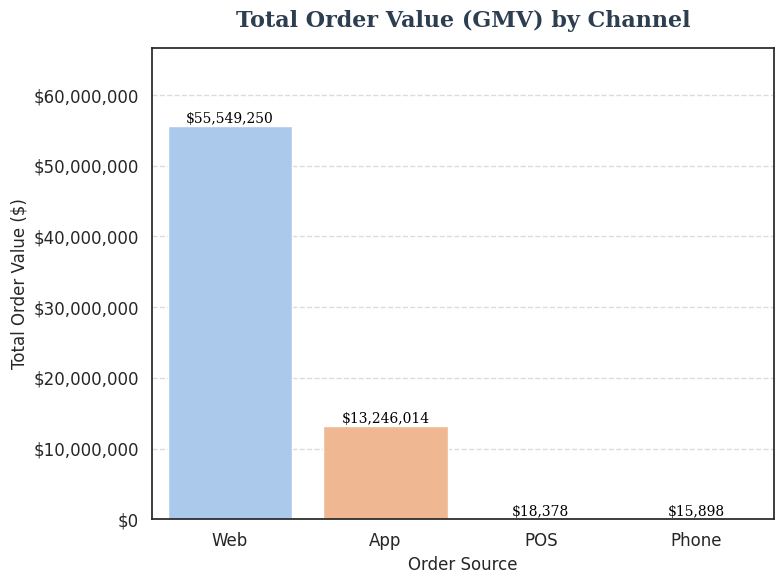

In [ ]:
# Calculate total GMV by channel
channel_gmv = df.groupby('ORDER_SOURCE')['GMV'].sum().reset_index().sort_values('GMV', ascending=False)
# Define pastel palette
palette = sns.color_palette("pastel", len(channel_gmv))

# Plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=channel_gmv, x='ORDER_SOURCE', y='GMV', hue='ORDER_SOURCE', palette=palette, legend=False)

# Title and labels
plt.title("Total Order Value (GMV) by Channel", fontsize=16, weight='bold', family='serif', color='#2c3e50', pad=15)
plt.xlabel('Order Source', fontsize=12)
plt.ylabel('Total Order Value ($)', fontsize=12)

# Format Y-axis as currency
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Add grid lines
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Add value labels
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'${height:,.0f}', (p.get_x() + p.get_width()/2, p.get_height()+5), ha='center', va='bottom', fontsize=10, color='black', family='serif')

# Increase y-axis range
max_height = max(p.get_height() for p in ax.patches)
ax.set_ylim(0, max_height * 1.2)

plt.tight_layout()
plt.show()

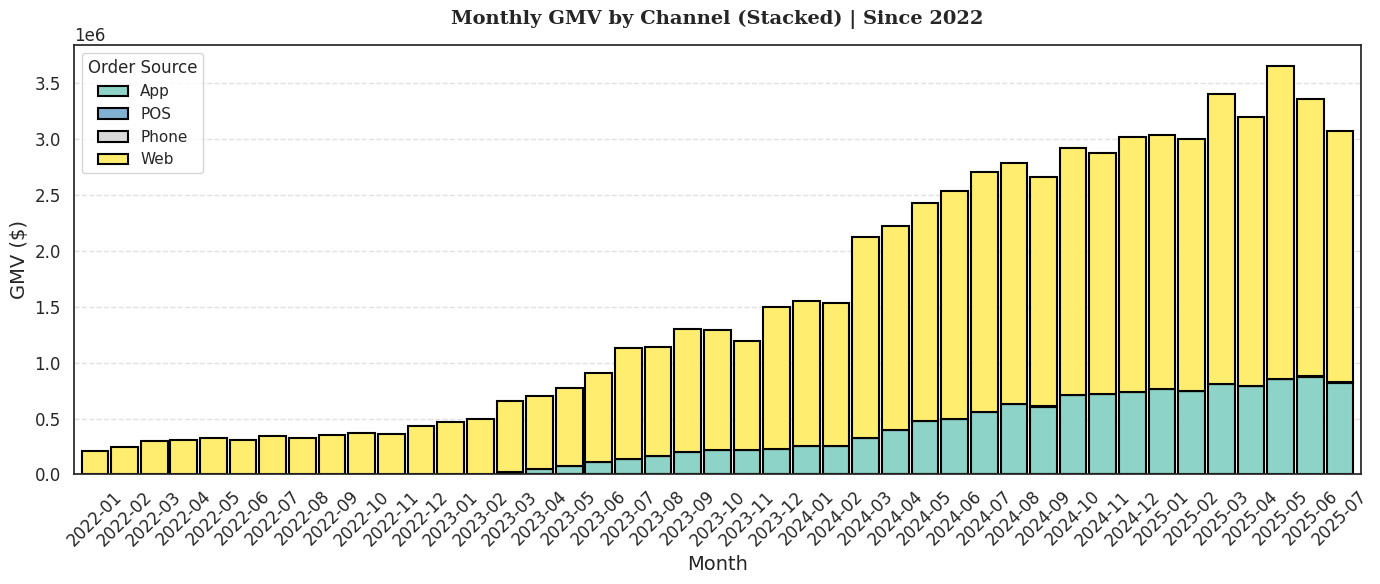

In [ ]:
df['order_month'] = pd.to_datetime(df['ORDER_CREATED_AT_PT']).dt.to_period('M')

# Filter for 2022 onwards
df_filtered = df[df['order_month'] >= pd.Period('2022-01', freq='M')]
channel_monthly_gmv = df_filtered.groupby(['order_month', 'ORDER_SOURCE'])['GMV'].sum().unstack().fillna(0)

# Plot
ax = channel_monthly_gmv.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='Set3', width=0.9)

# Add black edges to each bar segment
for patch in ax.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(1.5)

# Format Y-axis as dollar
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Titles and labels
plt.title('Monthly GMV by Channel (Stacked) | Since 2022', fontsize=14, weight='bold', family='serif', pad=15)
plt.xlabel('Month')
plt.ylabel('GMV ($)')
plt.xticks(rotation=45)
plt.legend(title='Order Source')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

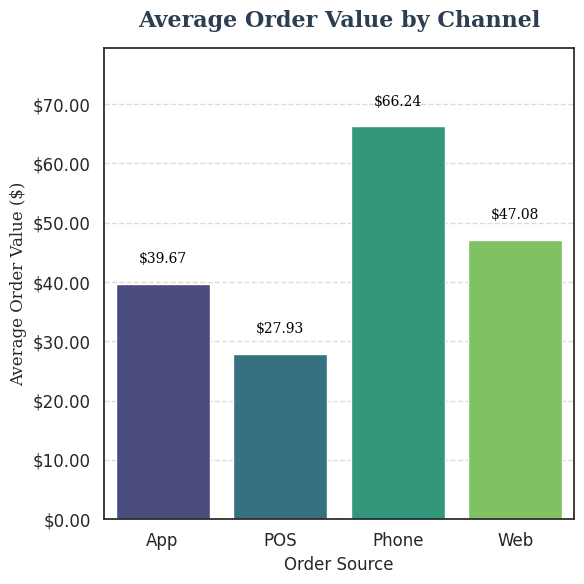

In [ ]:
plt.figure(figsize=(6,6))
palette = sns.color_palette("coolwarm", len(channel_metrics))
# Plot with palette
ax = sns.barplot(data=channel_metrics, x='ORDER_SOURCE', y='avg_order_value', hue='ORDER_SOURCE', palette=palette, edgecolor='black', legend=False)
# Title and labels with improved styling
plt.title("Average Order Value by Channel", fontsize=16, weight='bold', family='serif', color='#2c3e50', pad=15)
plt.xlabel('Order Source', fontsize=12)
plt.ylabel('Average Order Value ($)', fontsize=12, family='serif')
# Format y-axis as dollars
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.2f}'))
# Add grid lines
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
# Increase y-axis limit by 10% more than max height
max_height = max(p.get_height() for p in ax.patches)
ax.set_ylim(0, max_height * 1.2)
# Add data labels on bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'${height:.2f}', (p.get_x() + p.get_width() / 2, p.get_height() + 3), ha='center', va='bottom', fontsize=10, color='black', family='serif')
plt.tight_layout()
plt.show()

## **Dual-Axis Plot: GMV and Order Volume by Channel**

**The below visualization is a dual-axis bar + line plot to display both:**

- Total GMV (Gross Merchandise Value) – shown as bars

- Order Volume (number of orders) – shown as a line

This is ideal for comparing **monetary performance** and **engagement volume per channel**

/tmp/ipython-input-2450693923.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=channel_perf, x='ORDER_SOURCE', y='GMV', ax=ax1, palette=palette)


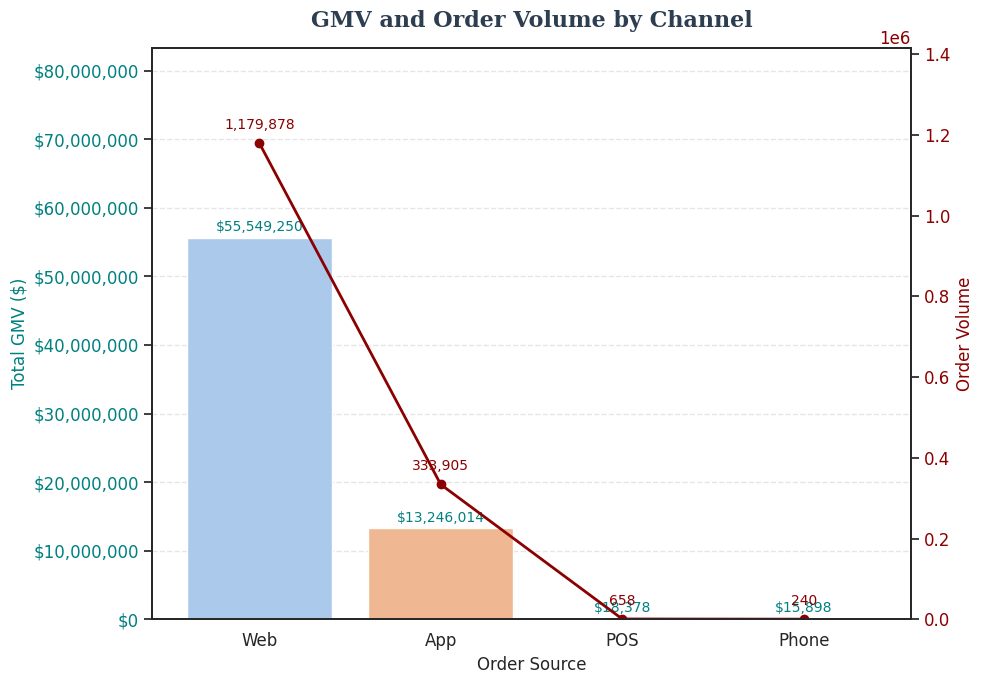

In [ ]:
# Group data: total GMV and number of orders by channel
channel_perf = df.groupby('ORDER_SOURCE').agg(GMV=('GMV', 'sum'), orders=('ORDER_ID', 'count')).reset_index().sort_values('GMV', ascending=False)

# Set figure and axis
fig, ax1 = plt.subplots(figsize=(10, 7))

# Bar plot for GMV (left axis)
palette = sns.color_palette("pastel", len(channel_perf))
sns.barplot(data=channel_perf, x='ORDER_SOURCE', y='GMV', ax=ax1, palette=palette)

max_gmv = channel_perf['GMV'].max()
ax1.set_ylim(0, max_gmv*1.5)
ax1.set_ylabel('Total GMV ($)', fontsize=12, color='teal')
ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax1.tick_params(axis='y', labelcolor='teal')
ax1.set_xlabel('Order Source', fontsize=12)
ax1.set_title("GMV and Order Volume by Channel", fontsize=16, weight='bold', family='serif', color='#2c3e50', pad=15)

# Add GMV value labels on bars
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'${height:,.0f}', (p.get_x() + p.get_width() / 2, height + max_gmv * 0.01), ha='center', va='bottom', fontsize=10, color='teal')

# Create secondary axis
ax2 = ax1.twinx()

# Line plot for order volume
ax2.plot(channel_perf['ORDER_SOURCE'], channel_perf['orders'], color='darkred', marker='o', linewidth=2, label='Order Volume')

# Set limits and labels
max_orders = channel_perf['orders'].max()
ax2.set_ylim(0, max_orders * 1.2)
ax2.set_ylabel('Order Volume', fontsize=12, color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')

# Add order volume annotations above points
for i, (x, y) in enumerate(zip(channel_perf['ORDER_SOURCE'], channel_perf['orders'])):
    ax2.annotate(f'{y:,}', (i, y + max_orders * 0.03), ha='center', fontsize=10, color='darkred')

# Grid and layout
ax1.yaxis.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**📊 What it shows:**

- Channels that drive high revenue (GMV) vs. Channels that drive high volume of orders

- This helps identify if a channel is high-value (GMV-heavy),  high-traffic (volume-heavy), or both.

## **Triple-Metric Plot: GMV, Orders & AOV by Channel**

/tmp/ipython-input-433206926.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=channel_perf, x='ORDER_SOURCE', y='GMV', ax=ax1, palette=palette)


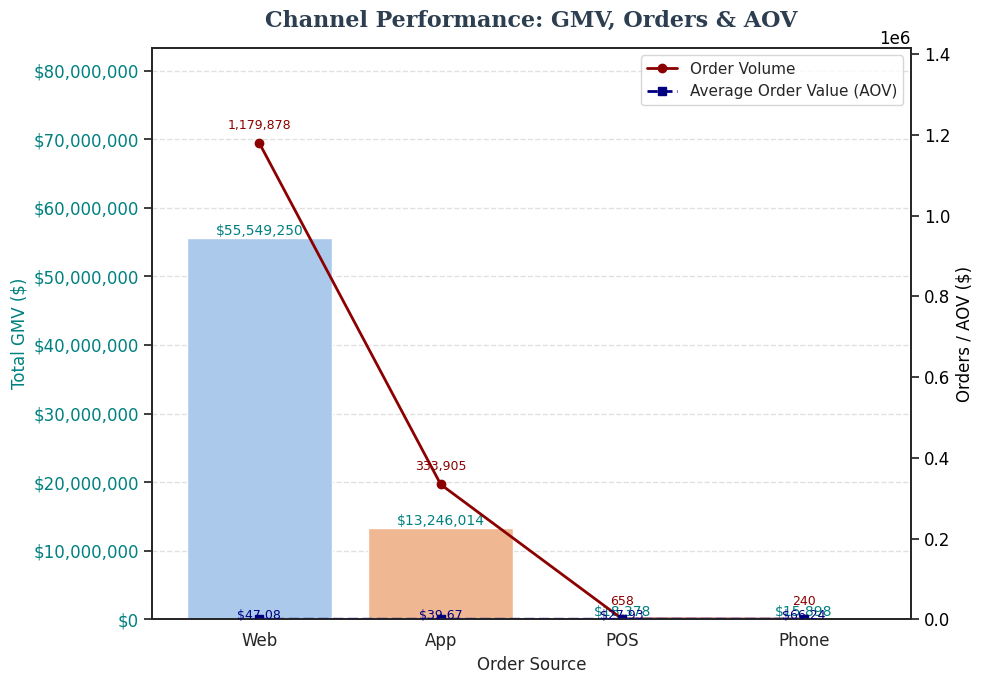

In [ ]:
# Aggregate data by order source
channel_perf = df.groupby('ORDER_SOURCE').agg(GMV=('GMV', 'sum'), orders=('ORDER_ID', 'count')).reset_index()

# Calculate AOV
channel_perf['AOV'] = channel_perf['GMV']/channel_perf['orders']

# Sort by GMV for display consistency
channel_perf = channel_perf.sort_values('GMV', ascending=False)

# Initialize figure and axis
fig, ax1 = plt.subplots(figsize=(10, 7))

# Barplot for GMV (Left Y-axis)
palette = sns.color_palette("pastel", len(channel_perf))
sns.barplot(data=channel_perf, x='ORDER_SOURCE', y='GMV', ax=ax1, palette=palette)
max_gmv = channel_perf['GMV'].max()
ax1.set_ylim(0, max_gmv*1.5)
ax1.set_ylabel('Total GMV ($)', fontsize=12, color='teal')
ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax1.set_xlabel('Order Source', fontsize=12)
ax1.set_title("Channel Performance: GMV, Orders & AOV", fontsize=16, weight='bold', family='serif', color='#2c3e50', pad=15)
ax1.tick_params(axis='y', labelcolor='teal')

# Add bar labels for GMV
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'${height:,.0f}', (p.get_x() + p.get_width()/2, height), ha='center', va='bottom', fontsize=10, color='teal')

# Twin axis for orders and AOV
ax2 = ax1.twinx()

# Line for Order Volume
ax2.set_ylim(0, max_orders * 1.2)
ax2.plot(channel_perf['ORDER_SOURCE'], channel_perf['orders'], color='darkred', marker='o', linewidth=2, label='Order Volume')

# Line for AOV
ax2.plot(channel_perf['ORDER_SOURCE'], channel_perf['AOV'], color='navy', marker='s', linewidth=2, linestyle='--', label='Average Order Value (AOV)')
ax2.set_ylabel('Orders / AOV ($)', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add data labels
for x, y1, y2 in zip(channel_perf['ORDER_SOURCE'], channel_perf['orders'], channel_perf['AOV']):
    ax2.annotate(f'{y1:,}', (x, y1 + max(channel_perf['orders']) * 0.03), ha='center', fontsize=9, color='darkred')
    ax2.annotate(f'${y2:,.2f}', (x, y2 + max(channel_perf['AOV']) * 0.03), ha='center', fontsize=9, color='navy')

# Legends
ax2.legend(loc='upper right')

# Grid and layout
ax1.yaxis.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# **8. UTM Tag Impact Analysis**

In [ ]:
df['has_utm'] = df['UTM_SOURCE'].notnull()
utm_comparison = df.groupby('has_utm').agg({'ORDER_ID': 'count', 'GMV': 'sum'}).rename(columns={'ORDER_ID': 'orders'})
utm_comparison['AOV'] = utm_comparison['GMV']/utm_comparison['orders']
utm_comparison

,orders,GMV,AOV
has_utm,,,
False,833517,35997665.70,43.19
True,681164,32831874.95,48.20


### **📊 UTM vs No-UTM AOV**

In [ ]:
print(df['has_utm'].value_counts())

has_utm
False    833517
True     681164
Name: count, dtype: int64


/tmp/ipython-input-1911536228.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=utm_comparison.reset_index(), x='has_utm', y='AOV', palette=sns.color_palette("pastel"))
/tmp/ipython-input-1911536228.py:2: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=utm_comparison.reset_index(), x='has_utm', y='AOV', palette=sns.color_palette("pastel"))


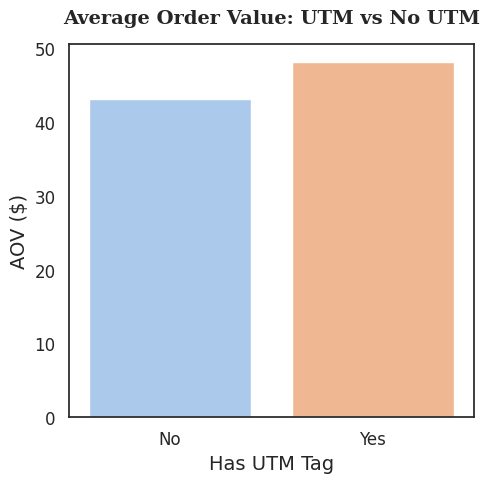

In [ ]:
plt.figure(figsize=(5,5))
sns.barplot(data=utm_comparison.reset_index(), x='has_utm', y='AOV', palette=sns.color_palette("pastel"))
plt.title("Average Order Value: UTM vs No UTM", fontsize=14, weight='bold', family='serif', pad=15)
plt.ylabel("AOV ($)")
plt.xlabel("Has UTM Tag")
plt.xticks([0, 1], ["No", "Yes"])
plt.tight_layout()
plt.show()

# **9. 📊 Location-Level Trends**

**Order volume and AOV over time | Analyzed by restaurant**

/tmp/ipython-input-2281428382.py:16: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(data=top_location_data, x='ORDER_CREATED_AT_PT', y='orders', hue='LOCATION_ID', palette=sns.color_palette("pastel"))


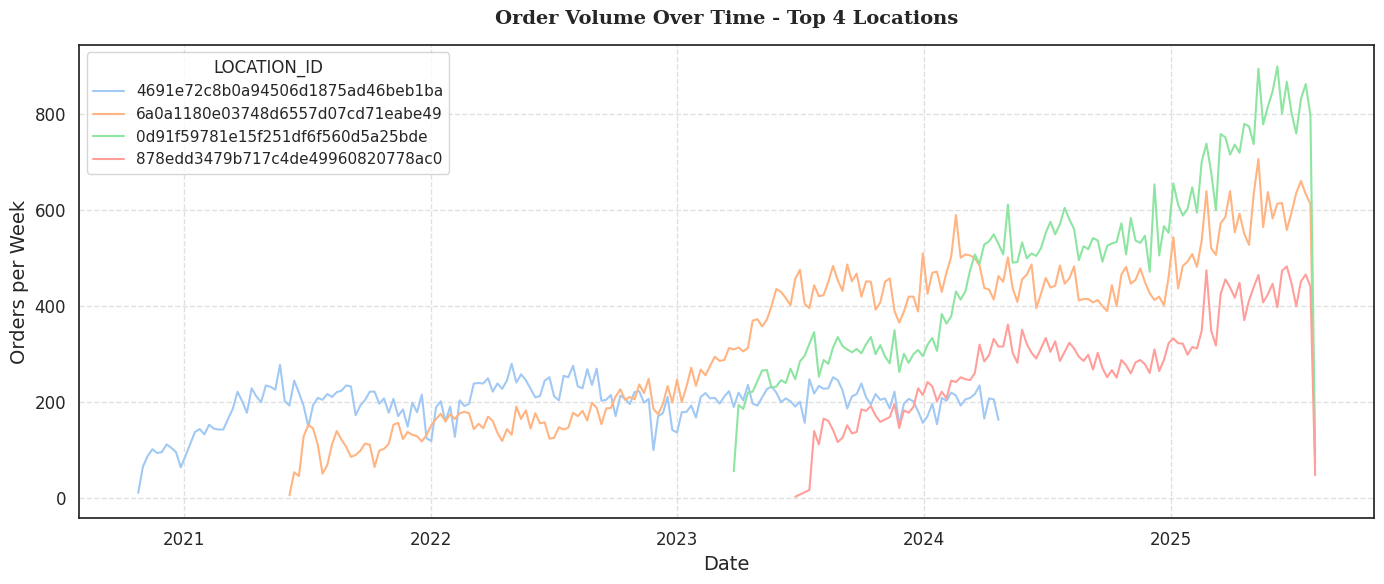

/tmp/ipython-input-2281428382.py:26: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(data=top_location_data, x='ORDER_CREATED_AT_PT', y='AOV', hue='LOCATION_ID', palette=sns.color_palette("pastel"))


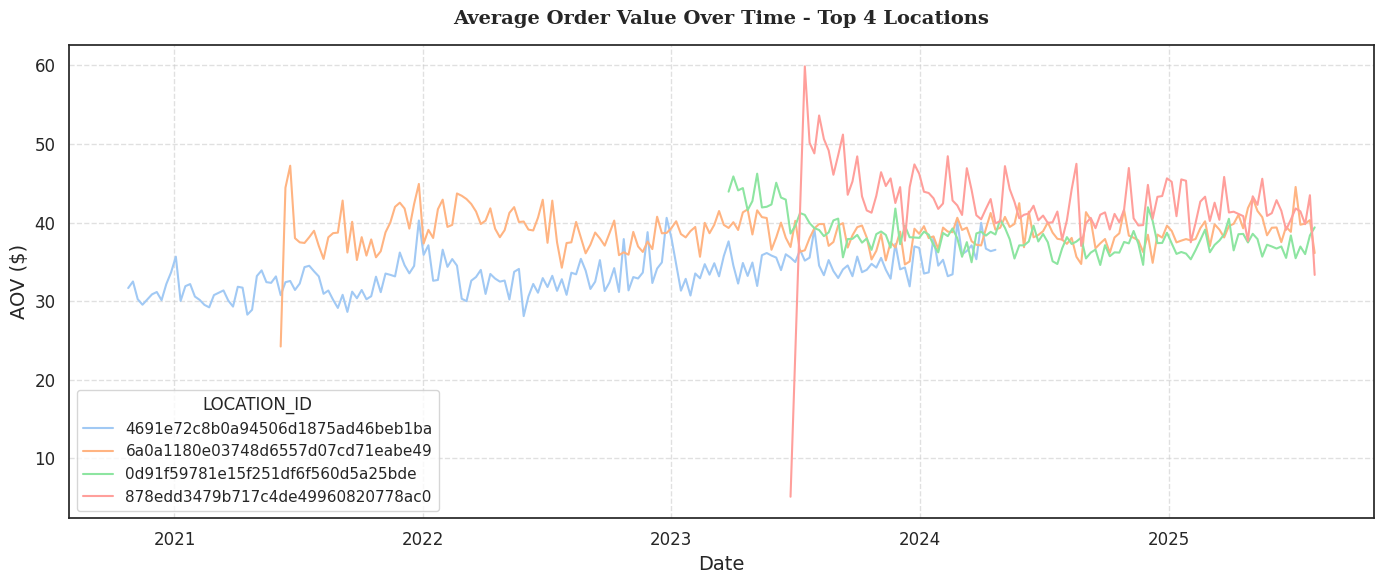

In [ ]:
# Ensure datetime format
df['ORDER_CREATED_AT_PT'] = pd.to_datetime(df['ORDER_CREATED_AT_PT'])
# Calculate AOV per order
df['AOV'] = df['GMV'] / df['NUMBER_OF_ITEMS']

# 1. AOV and Order Volume per Location Over Time
location_time = (df.groupby([pd.Grouper(key='ORDER_CREATED_AT_PT', freq='W'), 'LOCATION_ID']).agg(total_gmv=('GMV', 'sum'), orders=('ORDER_ID', 'count')).reset_index())
location_time['AOV'] = location_time['total_gmv']/location_time['orders']

# Top 4 busiest locations
top_locations = location_time.groupby('LOCATION_ID')['orders'].sum().nlargest(4).index
top_location_data = location_time[location_time['LOCATION_ID'].isin(top_locations)]

# Orders over time
plt.figure(figsize=(14, 6))
sns.lineplot(data=top_location_data, x='ORDER_CREATED_AT_PT', y='orders', hue='LOCATION_ID', palette=sns.color_palette("pastel"))
plt.title("Order Volume Over Time - Top 4 Locations", fontsize=14, weight='bold', family='serif', pad=15)
plt.xlabel("Date")
plt.ylabel("Orders per Week")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# AOV over time
plt.figure(figsize=(14, 6))
sns.lineplot(data=top_location_data, x='ORDER_CREATED_AT_PT', y='AOV', hue='LOCATION_ID', palette=sns.color_palette("pastel"))
plt.title("Average Order Value Over Time - Top 4 Locations", fontsize=14, weight='bold', family='serif', pad=15)
plt.xlabel("Date")
plt.ylabel("AOV ($)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Coupon Effectiveness: AOV by coupon usage (with vs. without coupon)**

In [ ]:
print(df[['GMV', 'HAS_COUPON']].head())
print(df['HAS_COUPON'].value_counts())
print(df['GMV'].describe())

    GMV  HAS_COUPON
0 24.96       False
1 42.13       False
2 55.58       False
3 27.35       False
4 17.50       False
HAS_COUPON
False    1385657
True      129024
Name: count, dtype: int64
count   1514681.00
mean         45.44
std          36.43
min          -5.00
25%          24.93
50%          38.17
75%          56.21
max        2851.42
Name: GMV, dtype: float64


   HAS_COUPON   AOV
0       False 45.59
1        True 46.30


/tmp/ipython-input-1982506619.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coupon_comparison, x='HAS_COUPON', y='AOV', palette='pastel')


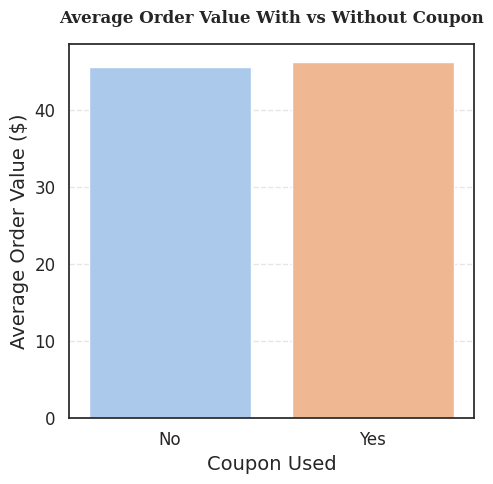

In [ ]:
# Filter only positive GMV orders
order_level_pos = df[df['GMV'] > 0].groupby('ORDER_ID').agg({'GMV': 'sum', 'HAS_COUPON': 'first'}).reset_index()

# Calculate mean GMV (AOV) by coupon use
coupon_comparison = order_level_pos.groupby('HAS_COUPON')['GMV'].mean().reset_index()
coupon_comparison.rename(columns={'GMV': 'AOV'}, inplace=True)

print(coupon_comparison)

# Plot with pastel palette
plt.figure(figsize=(5, 5))
sns.barplot(data=coupon_comparison, x='HAS_COUPON', y='AOV', palette='pastel')
plt.title("Average Order Value With vs Without Coupon", fontsize=12, weight='bold', family='serif', pad=15)
plt.xlabel("Coupon Used")
plt.ylabel("Average Order Value ($)")
plt.xticks([0, 1], ["No", "Yes"])
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

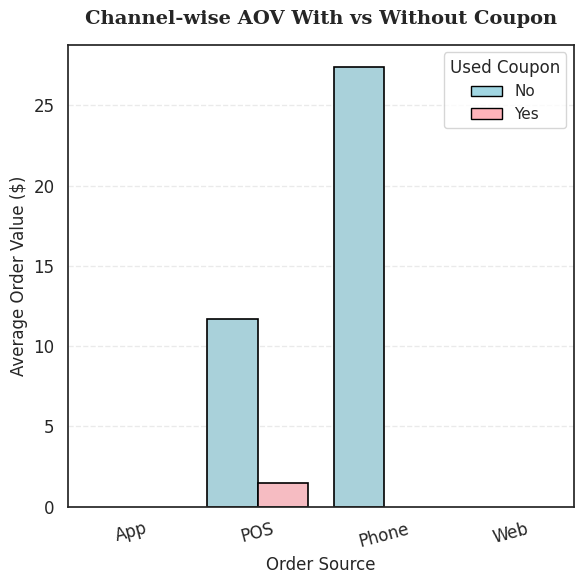

In [ ]:
# 3. Channel-specific Coupon Effectiveness
channel_coupon = (df.groupby(['ORDER_SOURCE', 'HAS_COUPON']).agg(AOV=('AOV', 'mean'), orders=('ORDER_ID', 'count')).reset_index())

# Define pastel colors manually for better control
pastel_colors = ['#A1D6E2', '#FFB3BA']  # light blue and pastel red
plt.figure(figsize=(6, 6))
sns.barplot(data=channel_coupon, x='ORDER_SOURCE', y='AOV', hue='HAS_COUPON', palette=pastel_colors, edgecolor='black', linewidth=1.2)

# Styling
plt.title("Channel-wise AOV With vs Without Coupon", fontsize=14, weight='bold', family='serif', pad=15)
plt.xlabel("Order Source", fontsize=12)
plt.ylabel("Average Order Value ($)", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.xticks(rotation=15)

# Custom legend with clear Yes/No labels
from matplotlib.patches import Patch
legend_patches = [Patch(facecolor=pastel_colors[0], edgecolor='black', label='No'),
                  Patch(facecolor=pastel_colors[1], edgecolor='black', label='Yes')]
plt.legend(title="Used Coupon", handles=legend_patches)

plt.tight_layout()
plt.show()

**Item Count vs. AOV — Explore Upselling Impact**

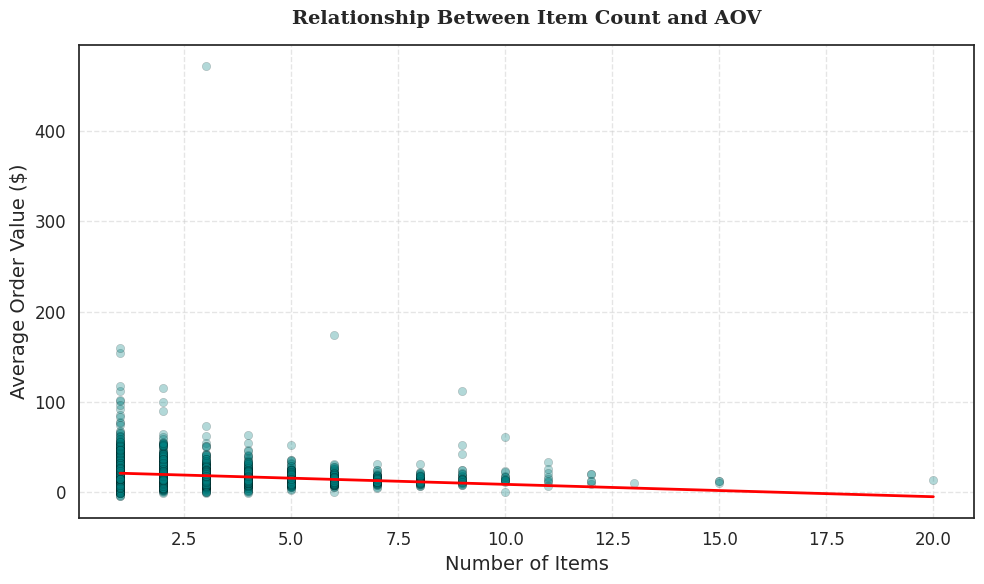

In [ ]:
sampled = df[df['NUMBER_OF_ITEMS'] > 0].sample(5000, random_state=42)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sampled, x='NUMBER_OF_ITEMS', y='AOV', alpha=0.3, edgecolor='black', linewidth=0.3, color='teal')
sns.regplot(data=sampled, x='NUMBER_OF_ITEMS', y='AOV', scatter=False, color='red', ci=None, line_kws={'linewidth': 2})
plt.title("Relationship Between Item Count and AOV", fontsize=14, weight='bold', family='serif', pad=15)
plt.xlabel("Number of Items")
plt.ylabel("Average Order Value ($)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/tmp/ipython-input-535183372.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'ORDER_CREATED_AT_PT': pd.date_range('2023-01-01', periods=n, freq='H'),


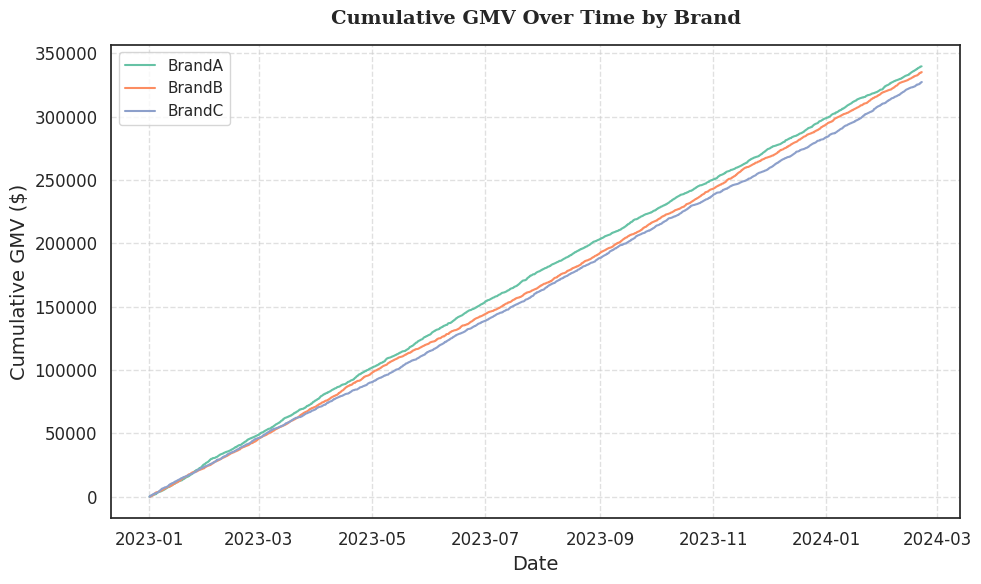

📊 AOV Summary by Delivery Type:
  DELIVERY_TYPE  mean  median  count   std
0      Delivery 31.75   24.43   2994 26.24
1        Pickup 31.82   24.59   3082 25.35

📌 T-Test p-value (Delivery vs Pickup): 0.9119


In [ ]:
# Simulated dataset
np.random.seed(42)
n = 10000
df = pd.DataFrame({
    'ORDER_ID': np.arange(n),
    'BRAND_ID': np.random.choice(['BrandA', 'BrandB', 'BrandC'], size=n),
    'LOCATION_ID': np.random.choice(['Loc1', 'Loc2', 'Loc3', 'Loc4'], size=n),
    'GUEST_ID': np.random.choice([f'Guest_{i}' for i in range(500)], size=n),
    'ORDER_CREATED_AT_PT': pd.date_range('2023-01-01', periods=n, freq='H'),
    'ORDER_TYPE': np.random.choice(['Dine-in', 'Takeaway'], size=n),
    'ORDER_SOURCE': np.random.choice(['App', 'Web', 'POS'], size=n),
    'DELIVERY_TYPE': np.random.choice(['Delivery', 'Pickup', None], size=n, p=[0.3, 0.3, 0.4]),
    'UTM_SOURCE': np.random.choice(['google', 'facebook', None], size=n),
    'UTM_MEDIUM': np.random.choice(['cpc', 'organic', None], size=n),
    'HAS_COUPON': np.random.choice([True, False], size=n),
    'COUPON_TYPE': np.random.choice(['Discount', 'BOGO', None], size=n),
    'NUMBER_OF_ITEMS': np.random.poisson(3, size=n) + 1,
    'DELIVERY_FEE': np.random.uniform(0, 10, size=n),
    'GMV': np.random.gamma(5, 20, size=n)})

# AOV
df['AOV'] = df['GMV']/df['NUMBER_OF_ITEMS']

# Cumulative GMV per BRAND
df['ORDER_CREATED_AT_PT'] = pd.to_datetime(df['ORDER_CREATED_AT_PT'])
df.sort_values('ORDER_CREATED_AT_PT', inplace=True)
df['cum_gmv'] = df.groupby('BRAND_ID')['GMV'].cumsum()

plt.figure(figsize=(10, 6))
for brand, group in df.groupby('BRAND_ID'):
    sns.lineplot(x=group['ORDER_CREATED_AT_PT'], y=group['cum_gmv'], label=brand)
plt.title('Cumulative GMV Over Time by Brand', fontsize=14, weight='bold', family='serif', pad=15)
plt.xlabel('Date')
plt.ylabel('Cumulative GMV ($)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend()
plt.show()

# AOV Comparison by Delivery Type
aov_delivery = df.dropna(subset=['DELIVERY_TYPE'])
aov_delivery_type = aov_delivery[aov_delivery['DELIVERY_TYPE'].isin(['Delivery', 'Pickup'])]

# T-test
t_stat, p_val = ttest_ind(aov_delivery_type[aov_delivery_type['DELIVERY_TYPE'] == 'Delivery']['AOV'], aov_delivery_type[aov_delivery_type['DELIVERY_TYPE'] == 'Pickup']['AOV'], equal_var=False)

# Summary table
summary = aov_delivery_type.groupby('DELIVERY_TYPE')['AOV'].agg(['mean', 'median', 'count', 'std']).reset_index()
print("📊 AOV Summary by Delivery Type:")
print(summary)
print(f"\n📌 T-Test p-value (Delivery vs Pickup): {p_val:.4f}")

## 10. Data Quality Assessment
 (**Rough here onward**)

In [ ]:
# Percent missing
missing = df.isnull().mean().sort_values(ascending=False) * 100
missing[missing > 0.05]

,0
DELIVERY_TYPE,39.24
UTM_SOURCE,33.24
COUPON_TYPE,33.07
UTM_MEDIUM,32.79


### 📊 **Visualize Missing Data | Missing values as a horizontal bar chart**

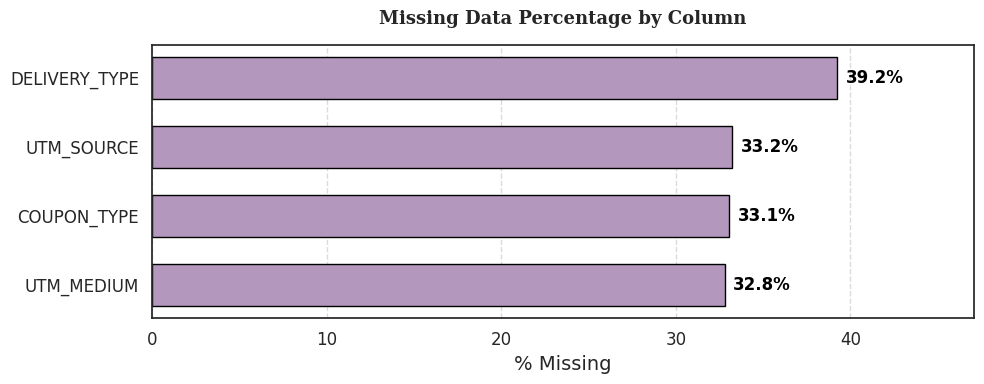

In [ ]:
missing_pct = df.isnull().mean().sort_values(ascending=True) * 100
missing_pct = missing_pct[missing_pct > 0]

plt.figure(figsize=(10, 4))
bars = plt.barh(missing_pct.index, missing_pct.values, color='#B497BD', edgecolor='black', height=0.6)

plt.title("Missing Data Percentage by Column", fontsize=13, weight='bold', family='serif', pad=15)
plt.xlabel("% Missing", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Increase x-axis limit a bit beyond max missing %
plt.xlim(0, missing_pct.max() * 1.2)

# Annotate each bar with the percentage value
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', va='center', fontsize=12, weight='bold', color='black')

plt.tight_layout()
plt.show()

/tmp/ipython-input-3018382005.py:14: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0, missing_filtered.max() * 100 * 1.2)  # scale by 100 here too
/tmp/ipython-input-3018382005.py:21: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


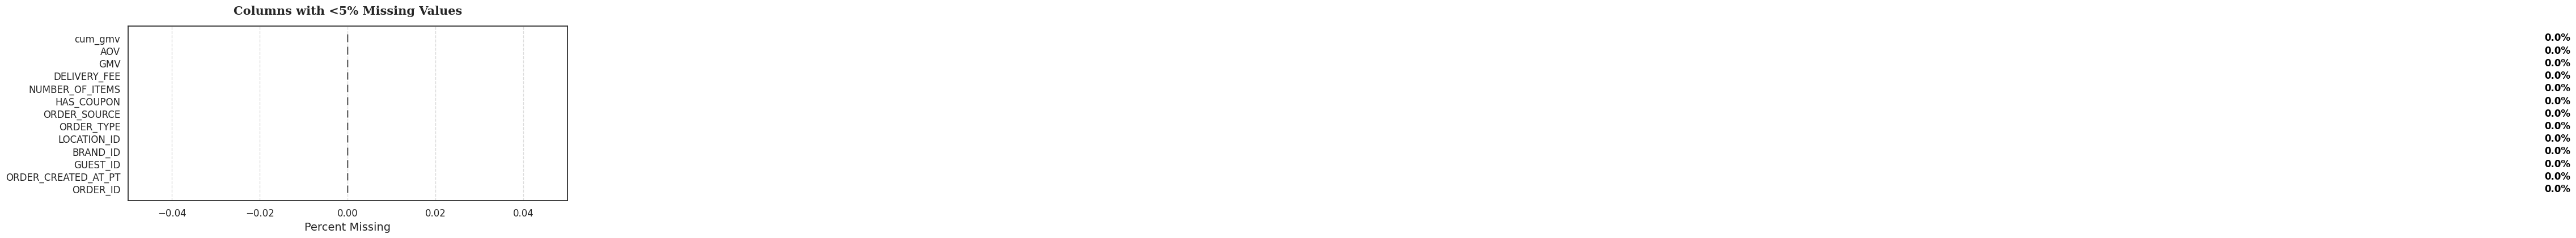

In [ ]:
plt.figure(figsize=(10, 4))

# Filter columns with less than 5% missing (i.e. < 0.05)
missing_filtered = missing[missing < 0.05]

# Plot bars — multiply by 100 to convert fraction to percentage
bars = plt.barh(missing_filtered.index, missing_filtered.values * 100, color='#FFB3BA', edgecolor='black', height=0.6)

plt.title("Columns with <5% Missing Values", fontsize=15, weight='bold', family='serif', pad=15)
plt.xlabel("Percent Missing", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Increase x-axis limit a bit beyond max missing %
plt.xlim(0, missing_filtered.max() * 100 * 1.2)  # scale by 100 here too

# Annotate bars with percentage values (width is already in %)
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', va='center', fontsize=12, weight='bold', color='black')

plt.tight_layout()
plt.show()

In [ ]:
# Check DELIVERY_TYPE vs ORDER_TYPE
df[['ORDER_TYPE', 'DELIVERY_TYPE']].drop_duplicates().sort_values(by='ORDER_TYPE')

,ORDER_TYPE,DELIVERY_TYPE
0,Dine-in,Pickup
1,Dine-in,None
5,Dine-in,Delivery
2,Takeaway,Delivery
4,Takeaway,None
7,Takeaway,Pickup


### **Check for duplicates**

In [ ]:
duplicates = df.duplicated(subset='ORDER_ID').sum()
print(f"Duplicate ORDER_IDs: {duplicates}")

Duplicate ORDER_IDs: 0


# **10. UTM Source Breakdown**

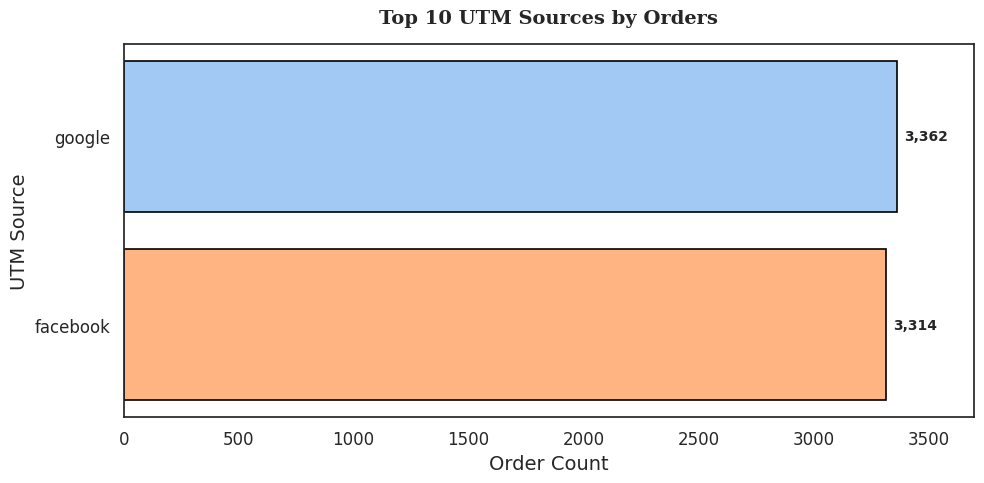

In [ ]:
# Prepare data
utm_stats = df[df['UTM_SOURCE'].notnull()].groupby('UTM_SOURCE').agg({'ORDER_ID': 'count', 'GMV': 'sum'}).sort_values('ORDER_ID', ascending=False).head(10)

# Create pastel color palette
palette = sns.color_palette("pastel", len(utm_stats))
fig, ax = plt.subplots(figsize=(10, 5))

# Plot bars with pastel colors and black edge
bars = ax.barh(utm_stats.index, utm_stats['ORDER_ID'], color=palette, edgecolor='black', linewidth=1.2)
# Extend x-axis range 10% beyond max value
max_orders = utm_stats['ORDER_ID'].max()
ax.set_xlim(0, max_orders * 1.1)

# Titles and labels
ax.set_title("Top 10 UTM Sources by Orders", fontsize=14, weight='bold', family='serif', pad=15)
ax.set_xlabel("Order Count")
ax.set_ylabel("UTM Source")

# Invert y-axis so highest bars on top
ax.invert_yaxis()

# Add order count labels on bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + max(utm_stats['ORDER_ID']) * 0.01, bar.get_y() + bar.get_height()/2, f'{width:,}', va='center', fontsize=10, weight='bold')

plt.tight_layout()
plt.show()

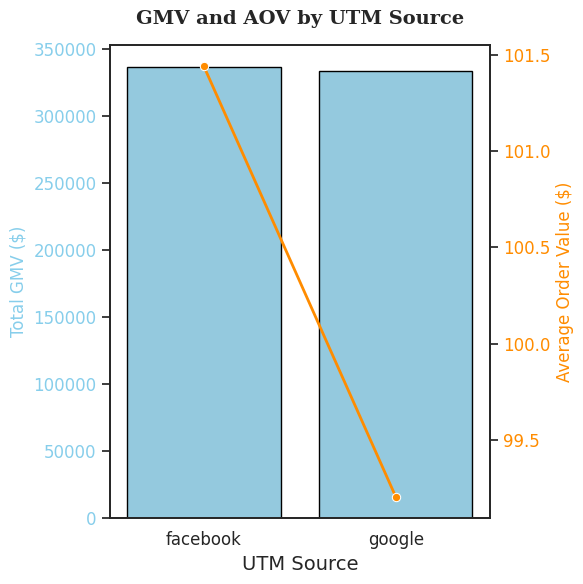

In [ ]:
# Sample aggregation: total GMV, total orders, and compute AOV per UTM_SOURCE
utm_stats = df[df['UTM_SOURCE'].notnull()].groupby('UTM_SOURCE').agg(
    total_gmv=('GMV', 'sum'),
    total_orders=('ORDER_ID', 'count')
).reset_index()
utm_stats['AOV'] = utm_stats['total_gmv'] / utm_stats['total_orders']

# Sort by GMV descending, take top 10
utm_stats = utm_stats.sort_values('total_gmv', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(6, 6))

# Bar plot for GMV (left y-axis)
sns.barplot(x='UTM_SOURCE', y='total_gmv', data=utm_stats, ax=ax1, color='skyblue', edgecolor='black')
ax1.set_ylabel('Total GMV ($)', color='skyblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xlabel('UTM Source')
ax1.set_title('GMV and AOV by UTM Source', fontsize=14, weight='bold', family='serif', pad=15)

# Create secondary axis for AOV
ax2 = ax1.twinx()
sns.lineplot(x='UTM_SOURCE', y='AOV', data=utm_stats, ax=ax2, color='darkorange', marker='o', linewidth=2)
ax2.set_ylabel('Average Order Value ($)', color='darkorange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='darkorange')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**SUMMARY**

What we have now - Through this notebook, I have addressed the below:

- Analyze product health metrics

- Compare performance by channel

- Understand guest behavior

- Assess data gaps that may skew marketing analysis

In [ ]:
# Set global styling
sns.set_theme(style="whitegrid", palette="Set2")
plt.rcParams.update({"axes.titlesize": 16, "axes.labelsize": 14, "xtick.labelsize": 12, "ytick.labelsize": 12, "figure.figsize": (12, 6)})

### **📈 1. Monthly GMV Trend with Gradient Fill**

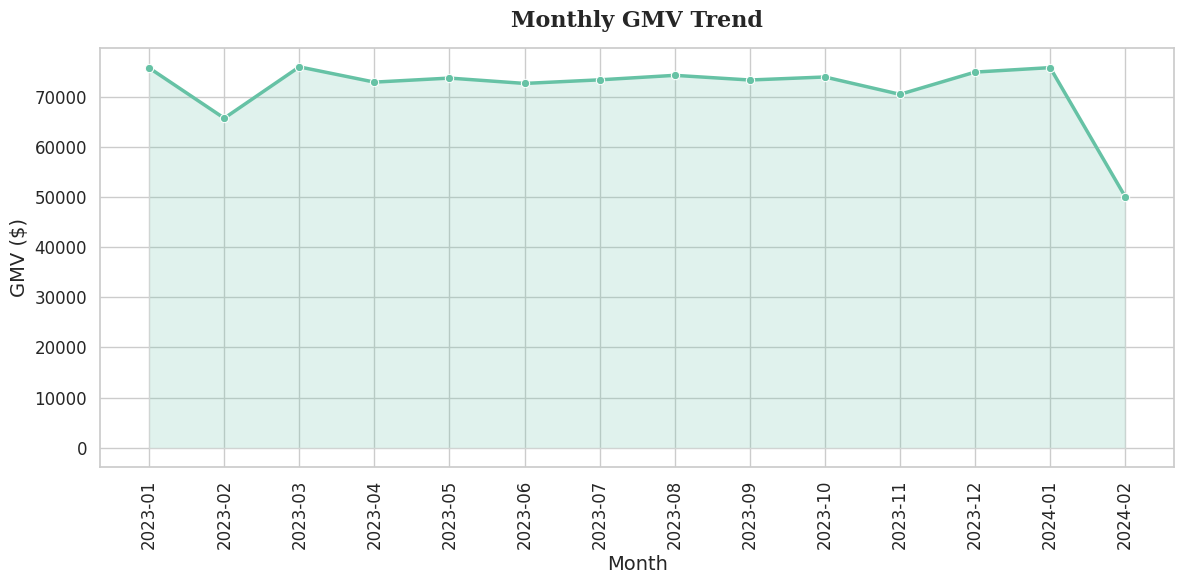

In [ ]:
df['order_month'] = df['ORDER_CREATED_AT_PT'].dt.to_period('M').astype(str)
monthly = df.groupby('order_month')['GMV'].sum().reset_index()

fig, ax = plt.subplots()
sns.lineplot(data=monthly, x='order_month', y='GMV', marker='o', linewidth=2.5, ax=ax)
ax.fill_between(monthly['order_month'], monthly['GMV'], alpha=0.2)
plt.xticks(rotation=90)
plt.title("Monthly GMV Trend", fontsize=16, weight='bold', family='serif', pad=15)
plt.ylabel("GMV ($)")
plt.xlabel("Month")
plt.tight_layout()
plt.show()

### **📊 2. Order Type Split (Stacked Bar Chart)**

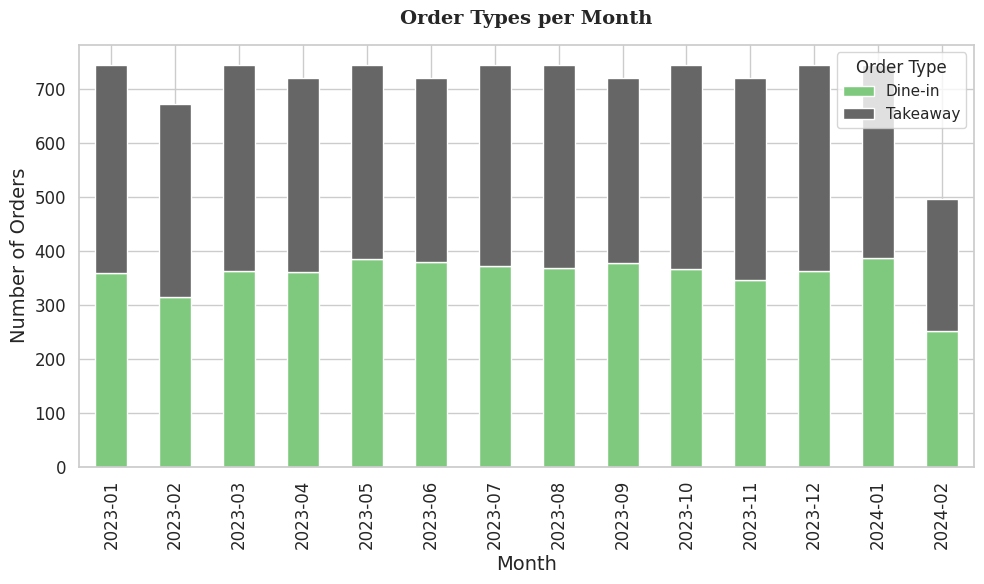

In [ ]:
order_type_counts = df.groupby(['order_month', 'ORDER_TYPE'])['ORDER_ID'].count().unstack().fillna(0)
order_type_counts.plot(kind='bar', stacked=True, colormap='Accent', figsize=(10,6))

plt.title("Order Types per Month", fontsize=14, weight='bold', family='serif', pad=15)
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.xticks(rotation=90)
plt.legend(title="Order Type")
plt.tight_layout()
plt.show()

**These visuals are presentation-ready and cover:**

- GMV and order trends

- Channel performance

- Guest retention

- Time-of-day ordering behavior

- Data quality